# 5. Identification based on traffic

In [1]:
# import numpy for math calculations
import numpy as np

# import pandas for data (csv) manipulation
import pandas as pd

# import matplotlib for plotting
import matplotlib.pyplot as plt

import sys  
sys.path.insert(1, '../src/')

from train_model import ClassifierEvaluator
from visualize import VisualizationUtils
import seaborn as sns
# import shap for ai explainability
import shap

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn import tree

# import warnings to hide the unnessairy warniings
import warnings
warnings.filterwarnings('ignore')

In [2]:
mov_slow = pd.read_csv('../data/processed/movement_slow_stat_cleaned.csv').drop(columns=['Unnamed: 0']).fillna(0)
mov_fast = pd.read_csv('../data/processed/movement_fast_stat_cleaned.csv').drop(columns=['Unnamed: 0']).fillna(0)
traffic_slow = pd.read_csv('../data/processed/traffic_slow_stat_cleaned.csv', index_col=0).fillna(0)
traffic_fast = pd.read_csv('../data/processed/traffic_fast_stat_cleaned.csv', index_col=0).fillna(0)

### 5.1. Training On Cooking Similator

In [3]:
evaluator = ClassifierEvaluator()
X, y, fX, fy, X_train, y_train, X_test, y_test, fX_train, fy_train, fX_test, fy_test = evaluator.split_data(traffic_slow, traffic_fast, id_range=range(0,30), train_minutes=8, test_minutes=2)

Size of the training set:  (1439, 28)
Size of the slow testing set:  (360, 28)
Size of the fast training set:  (1440, 28)
Size of the fast testing set:  (360, 28)


In [4]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(X_train,y_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Slow)').style.background_gradient(cmap= plt.cm.Blues)

 83%|██████████████████████████████████████████████████████████▎           | 5/6 [00:08<00:02,  2.03s/it]/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.74s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),F1(Fast),Precision(Train),Precision(Slow),Precision(Fast),Recall(Train),Recall(Slow),Recall(Fast),Log_loss(Train),Log_loss(Slow),Log_loss(Fast)
3,LogisticRegression,0.459347,0.322222,0.200000,0.412236,0.276351,0.125400,0.524272,0.344199,0.114759,0.459545,0.322222,0.200000,2.283692,2.307151,2.941872
0,ExtraTreesClassifier,1.000000,0.522222,0.183333,1.000000,0.509255,0.098087,1.000000,0.621333,0.080343,1.000000,0.522222,0.183333,0.000000,1.600196,4.428744
4,LGBMClassifier,1.000000,0.583333,0.155556,1.000000,0.579364,0.109723,1.000000,0.624474,0.109200,1.000000,0.583333,0.155556,0.000064,1.956552,5.617206
1,RandomForestClassifier,1.000000,0.602778,0.180556,1.000000,0.587070,0.111998,1.000000,0.628752,0.096348,1.000000,0.602778,0.180556,0.221254,1.602389,12.747292
5,VotingClassifier,1.000000,0.800000,0.194444,1.000000,0.791842,0.118078,1.000000,0.824917,0.102464,1.000000,0.800000,0.194444,0.239478,1.057092,3.514498
2,QuadraticDiscriminantAnalysis,0.981932,0.825000,0.122222,0.981203,0.831142,0.054881,0.986481,0.890165,0.039627,0.981944,0.825000,0.122222,0.270435,5.587943,31.638318


In [5]:
explainer = shap.TreeExplainer(best_model_slow)
shap_values_slow = explainer.shap_values(X_test)

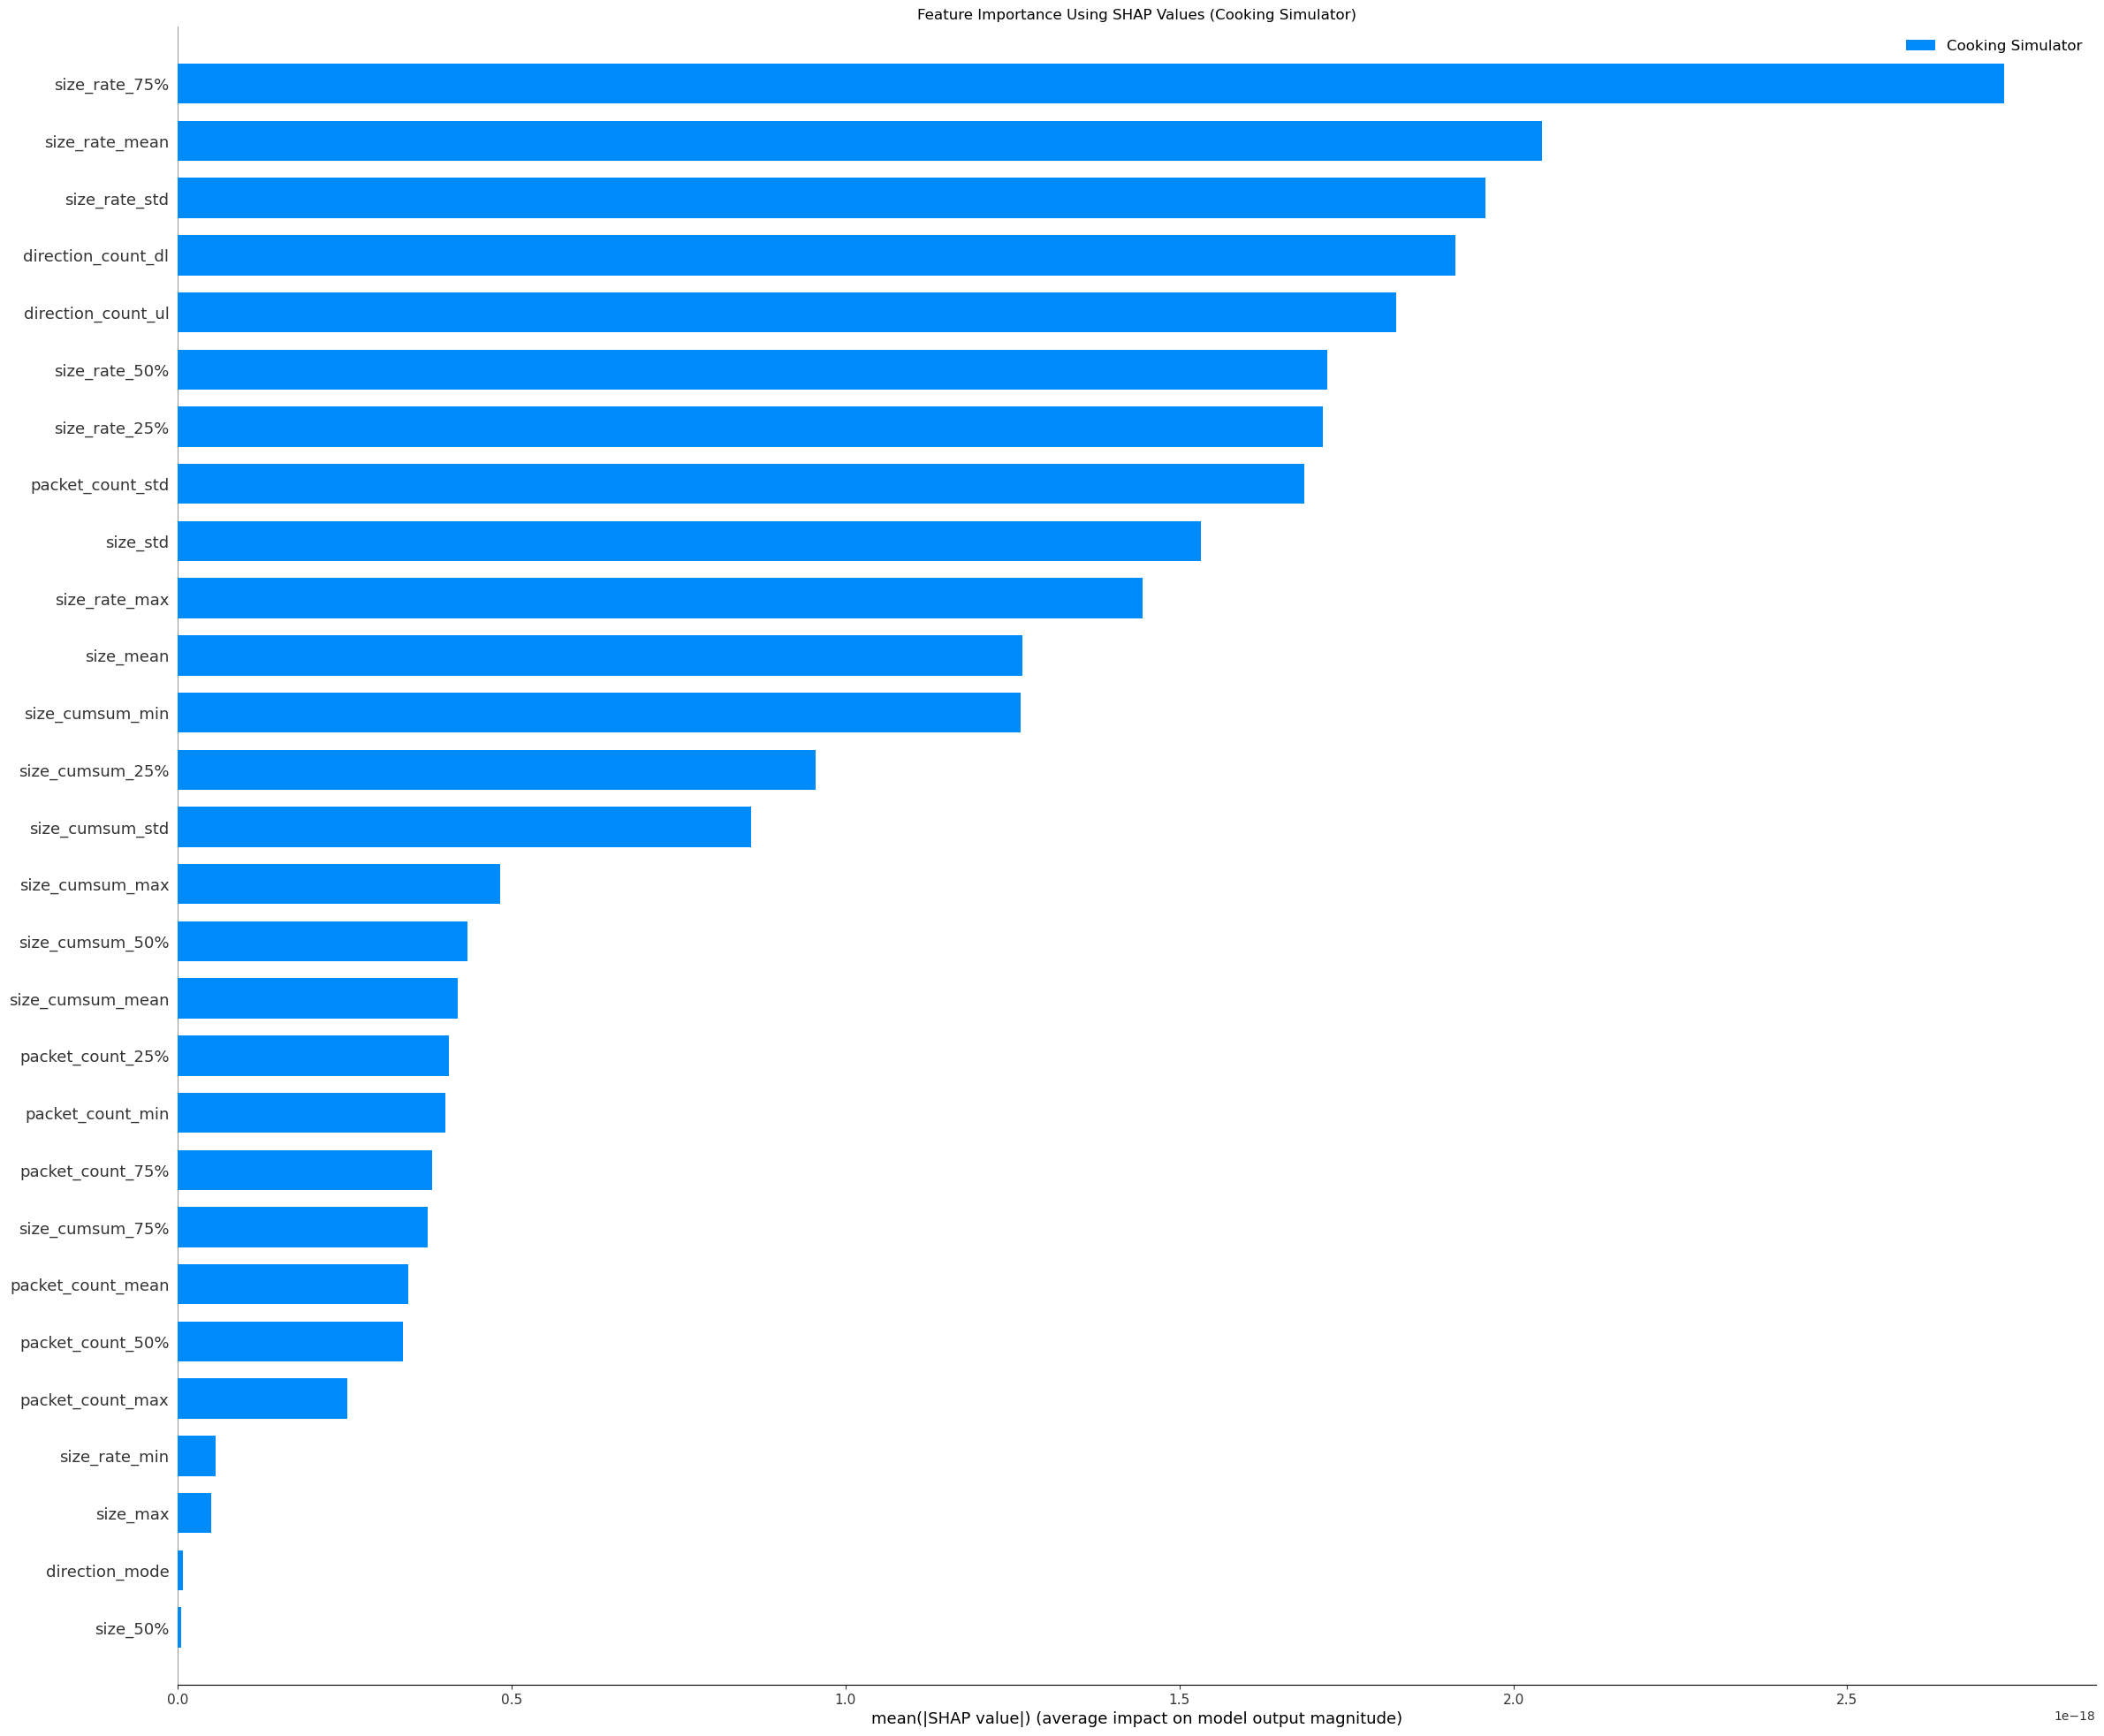

In [6]:
VisualizationUtils.shap_plotter([np.mean(shap_values_slow, axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (Cooking Simulator)",
                          class_names=['Cooking Simulator'])

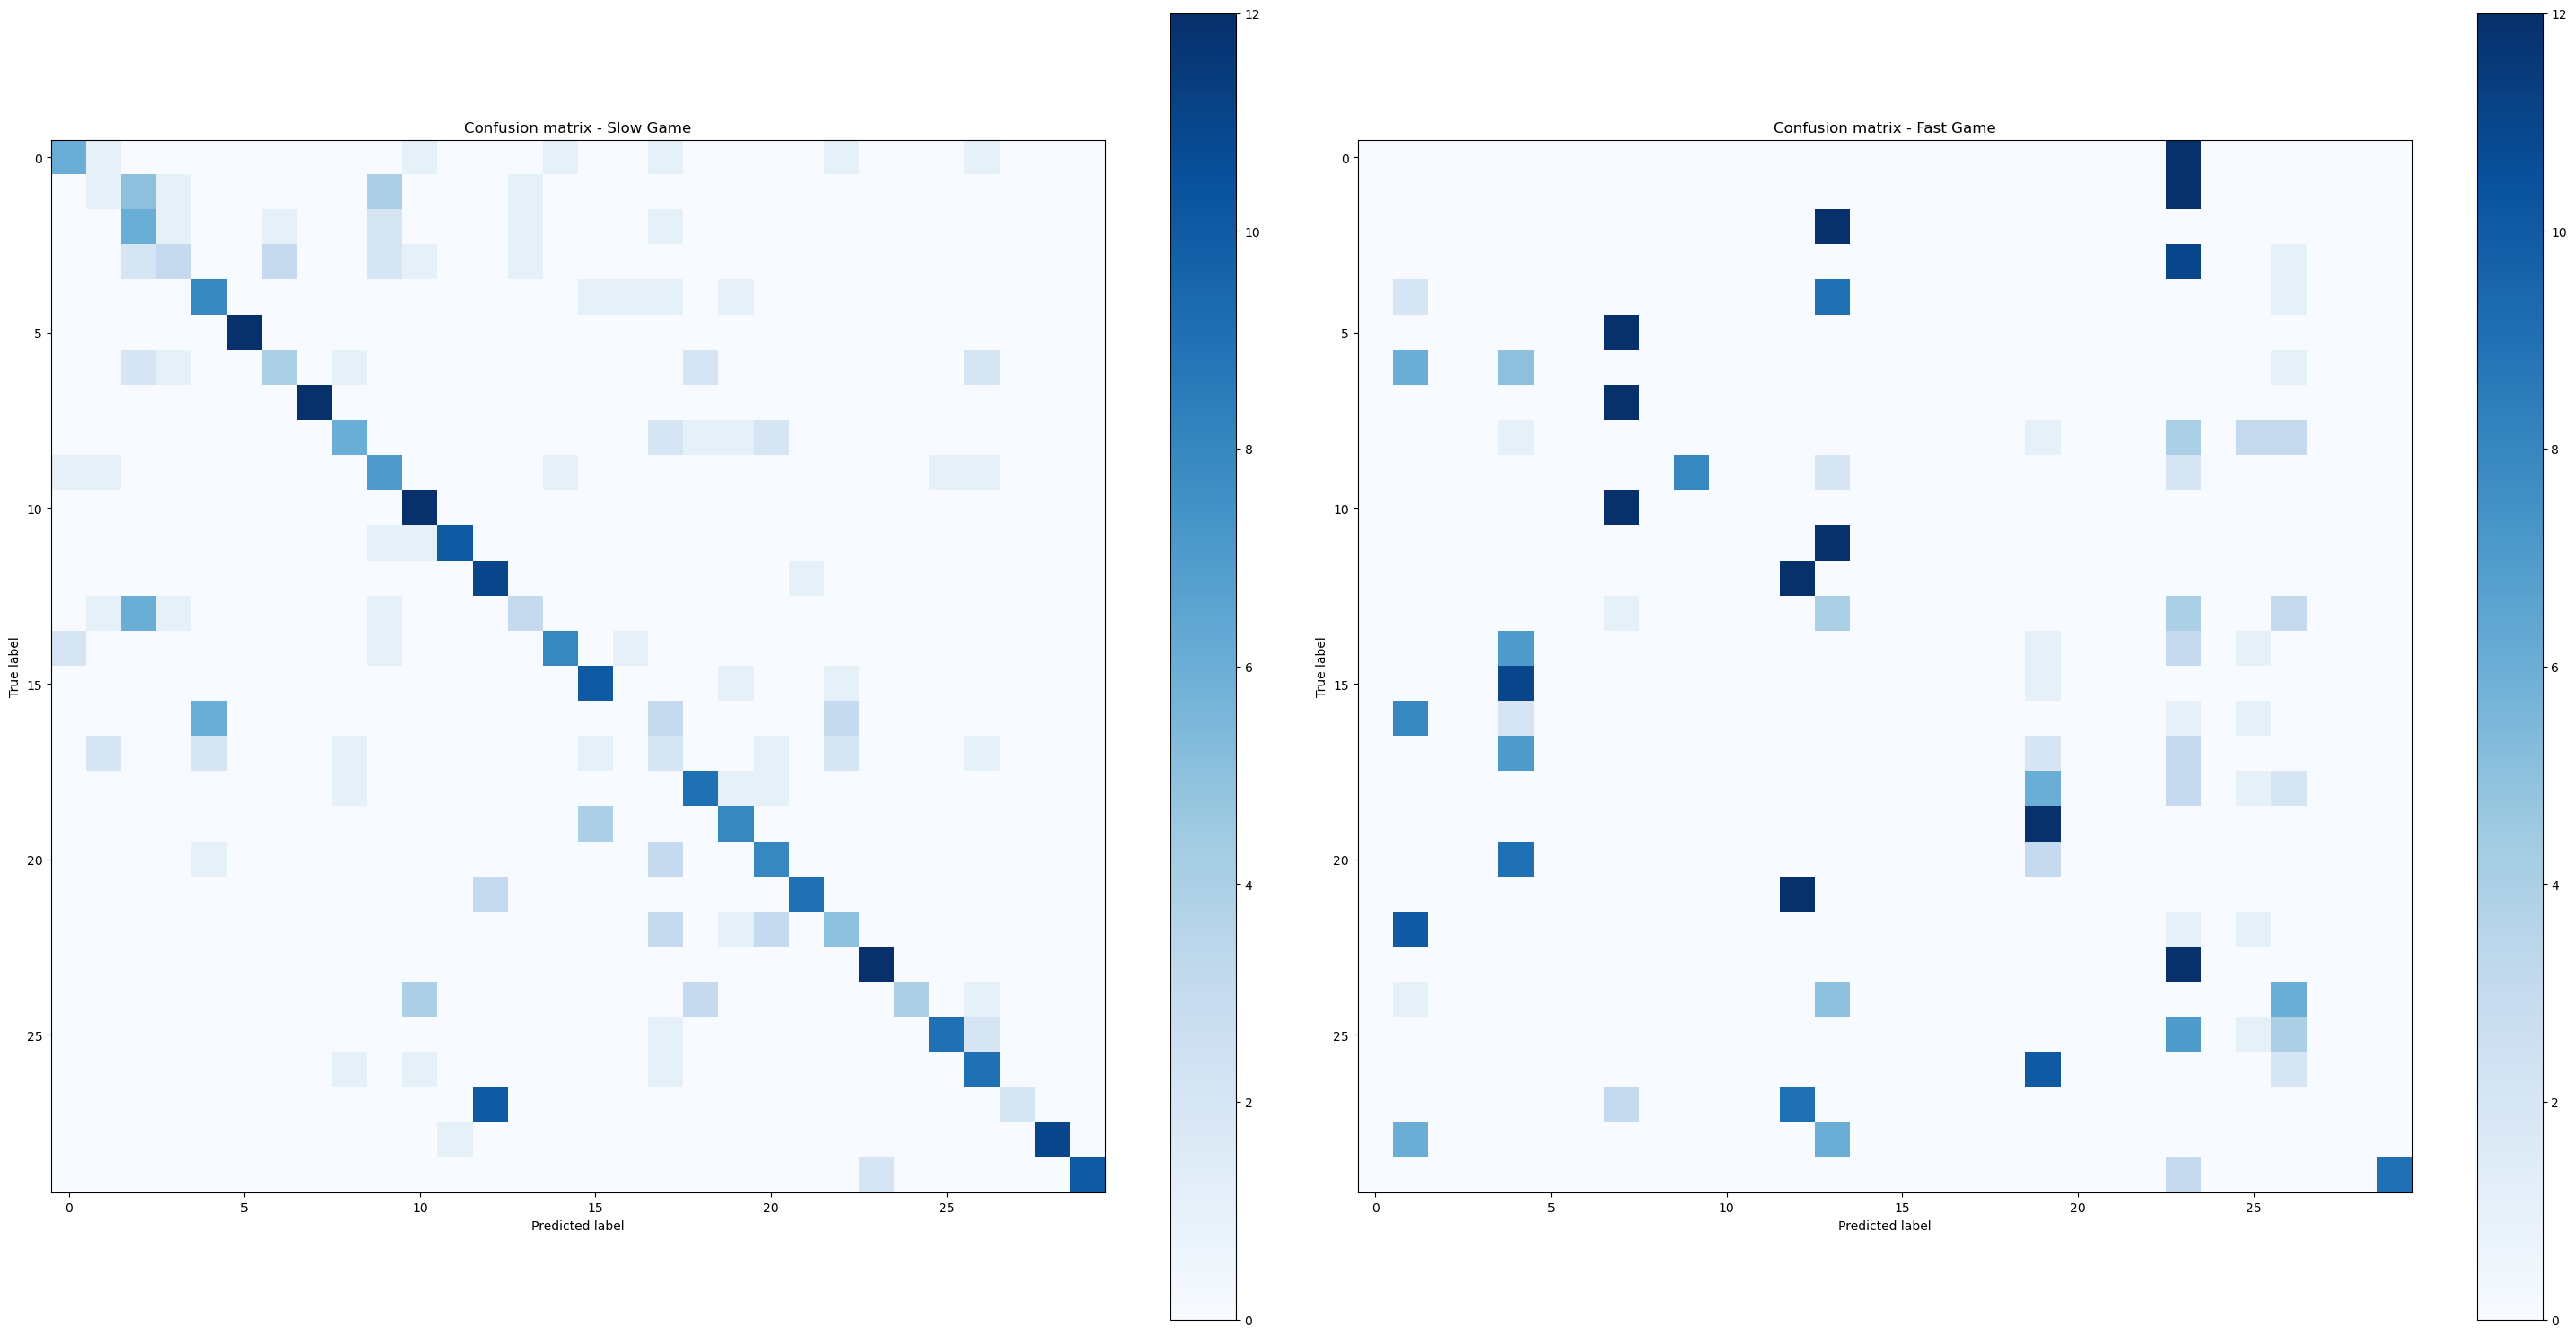

In [7]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

In [8]:
# Find the participant with the highest misclassification
misclassified_participant = np.argmax(np.sum(cm_slow, axis=1) - np.diag(cm_slow))
confused_with = np.argmax(cm_slow[misclassified_participant, :])
print(f"Participant {misclassified_participant} is most often misclassified as {confused_with}")

Participant 16 is most often misclassified as 4


In [9]:
# Compare features between the misclassified participant and the one they're confused with
features_to_compare = [col for col in mov_slow.columns if col != 'ID']
misclassified_data = mov_slow[mov_slow['ID'] == misclassified_participant][features_to_compare]
confused_with_data = mov_slow[mov_slow['ID'] == confused_with][features_to_compare]

In [10]:
# Calculate feature similarities
similarities = 1 - np.abs(misclassified_data.mean() - confused_with_data.mean()) / (misclassified_data.mean() + confused_with_data.mean())

# Sort features by similarity
most_similar_features = similarities.sort_values(ascending=False)

In [11]:
print("\nTop 10 most similar features:")
print(most_similar_features.head(10))


Top 10 most similar features:
time_interval                  1.000000
Accel_HeadPosX_mean            1.000000
Accel_LeftTouchPosZ_mean       1.000000
Accel_HeadPosY_mean            0.999999
Accel_HeadPosZ_mean            0.999999
Accel_HeadPosX_min             0.999999
Head_OrientationAccelX_mean    0.999998
Accel_RightTouchPosX_mean      0.999998
Head_OrientationAccelY_min     0.999997
Accel_RightTouchPosY_mean      0.999995
dtype: float64


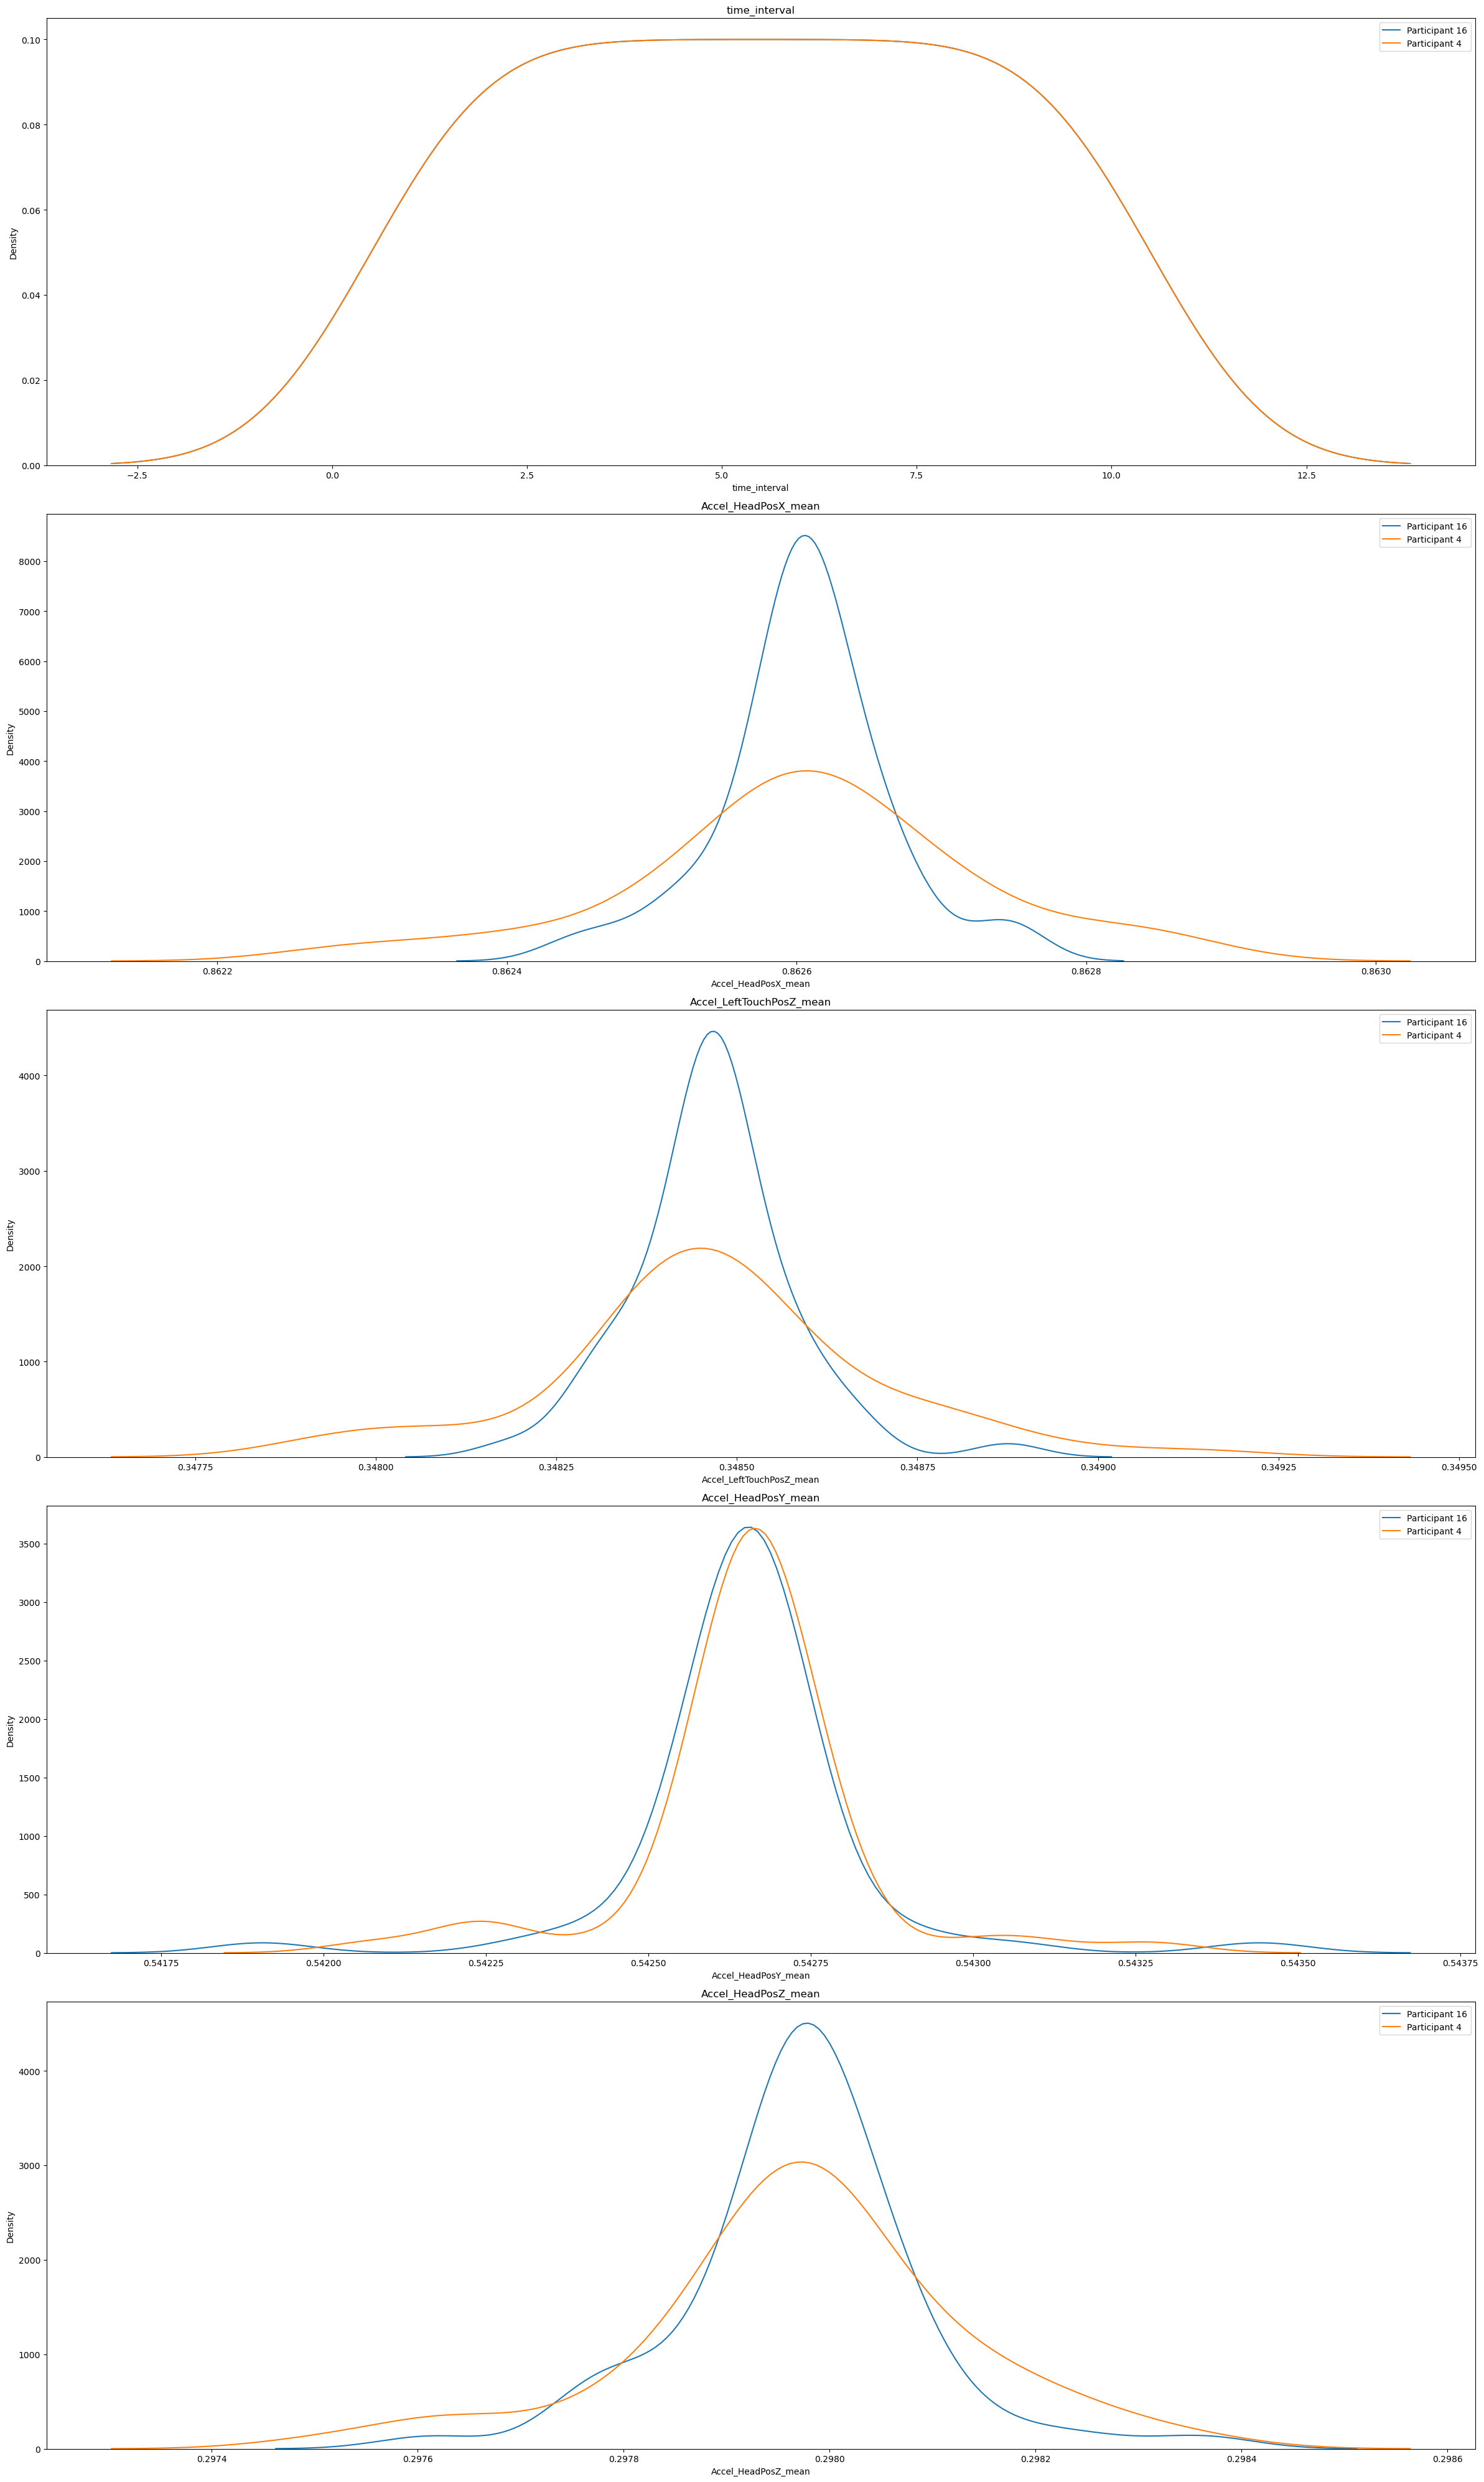

In [12]:
# Visualize feature distributions for top 5 similar features
top_5_features = most_similar_features.head(5).index

fig, axes = plt.subplots(5, 1, figsize=(24, 40))
for i, feature in enumerate(top_5_features):
    sns.kdeplot(data=misclassified_data[feature], ax=axes[i], label=f"Participant {misclassified_participant}")
    sns.kdeplot(data=confused_with_data[feature], ax=axes[i], label=f"Participant {confused_with}")
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [13]:
# Analyze differences in other features
differences = np.abs(misclassified_data.mean() - confused_with_data.mean()) / (misclassified_data.mean() + confused_with_data.mean())
most_different_features = differences.sort_values(ascending=False)

print("\nTop 10 most different features:")
print(most_different_features.head(10))


Top 10 most different features:
Accel_LeftTouchPosZ_max                0.828800
Accel_LeftTouchPosZ_std                0.648402
LeftTouchOrientationW_min              0.645923
Accel_LeftTouchPosY_max                0.610782
RightTouch_OrientationAccelX_std       0.602306
RightTouchOrientationW_min             0.593859
HeadOrientationY_min                   0.585914
Accel_LeftTouchPosX_max                0.581526
RightTouch_OrientationVelocityX_max    0.580727
RightTouch_OrientationVelocityZ_max    0.572931
dtype: float64


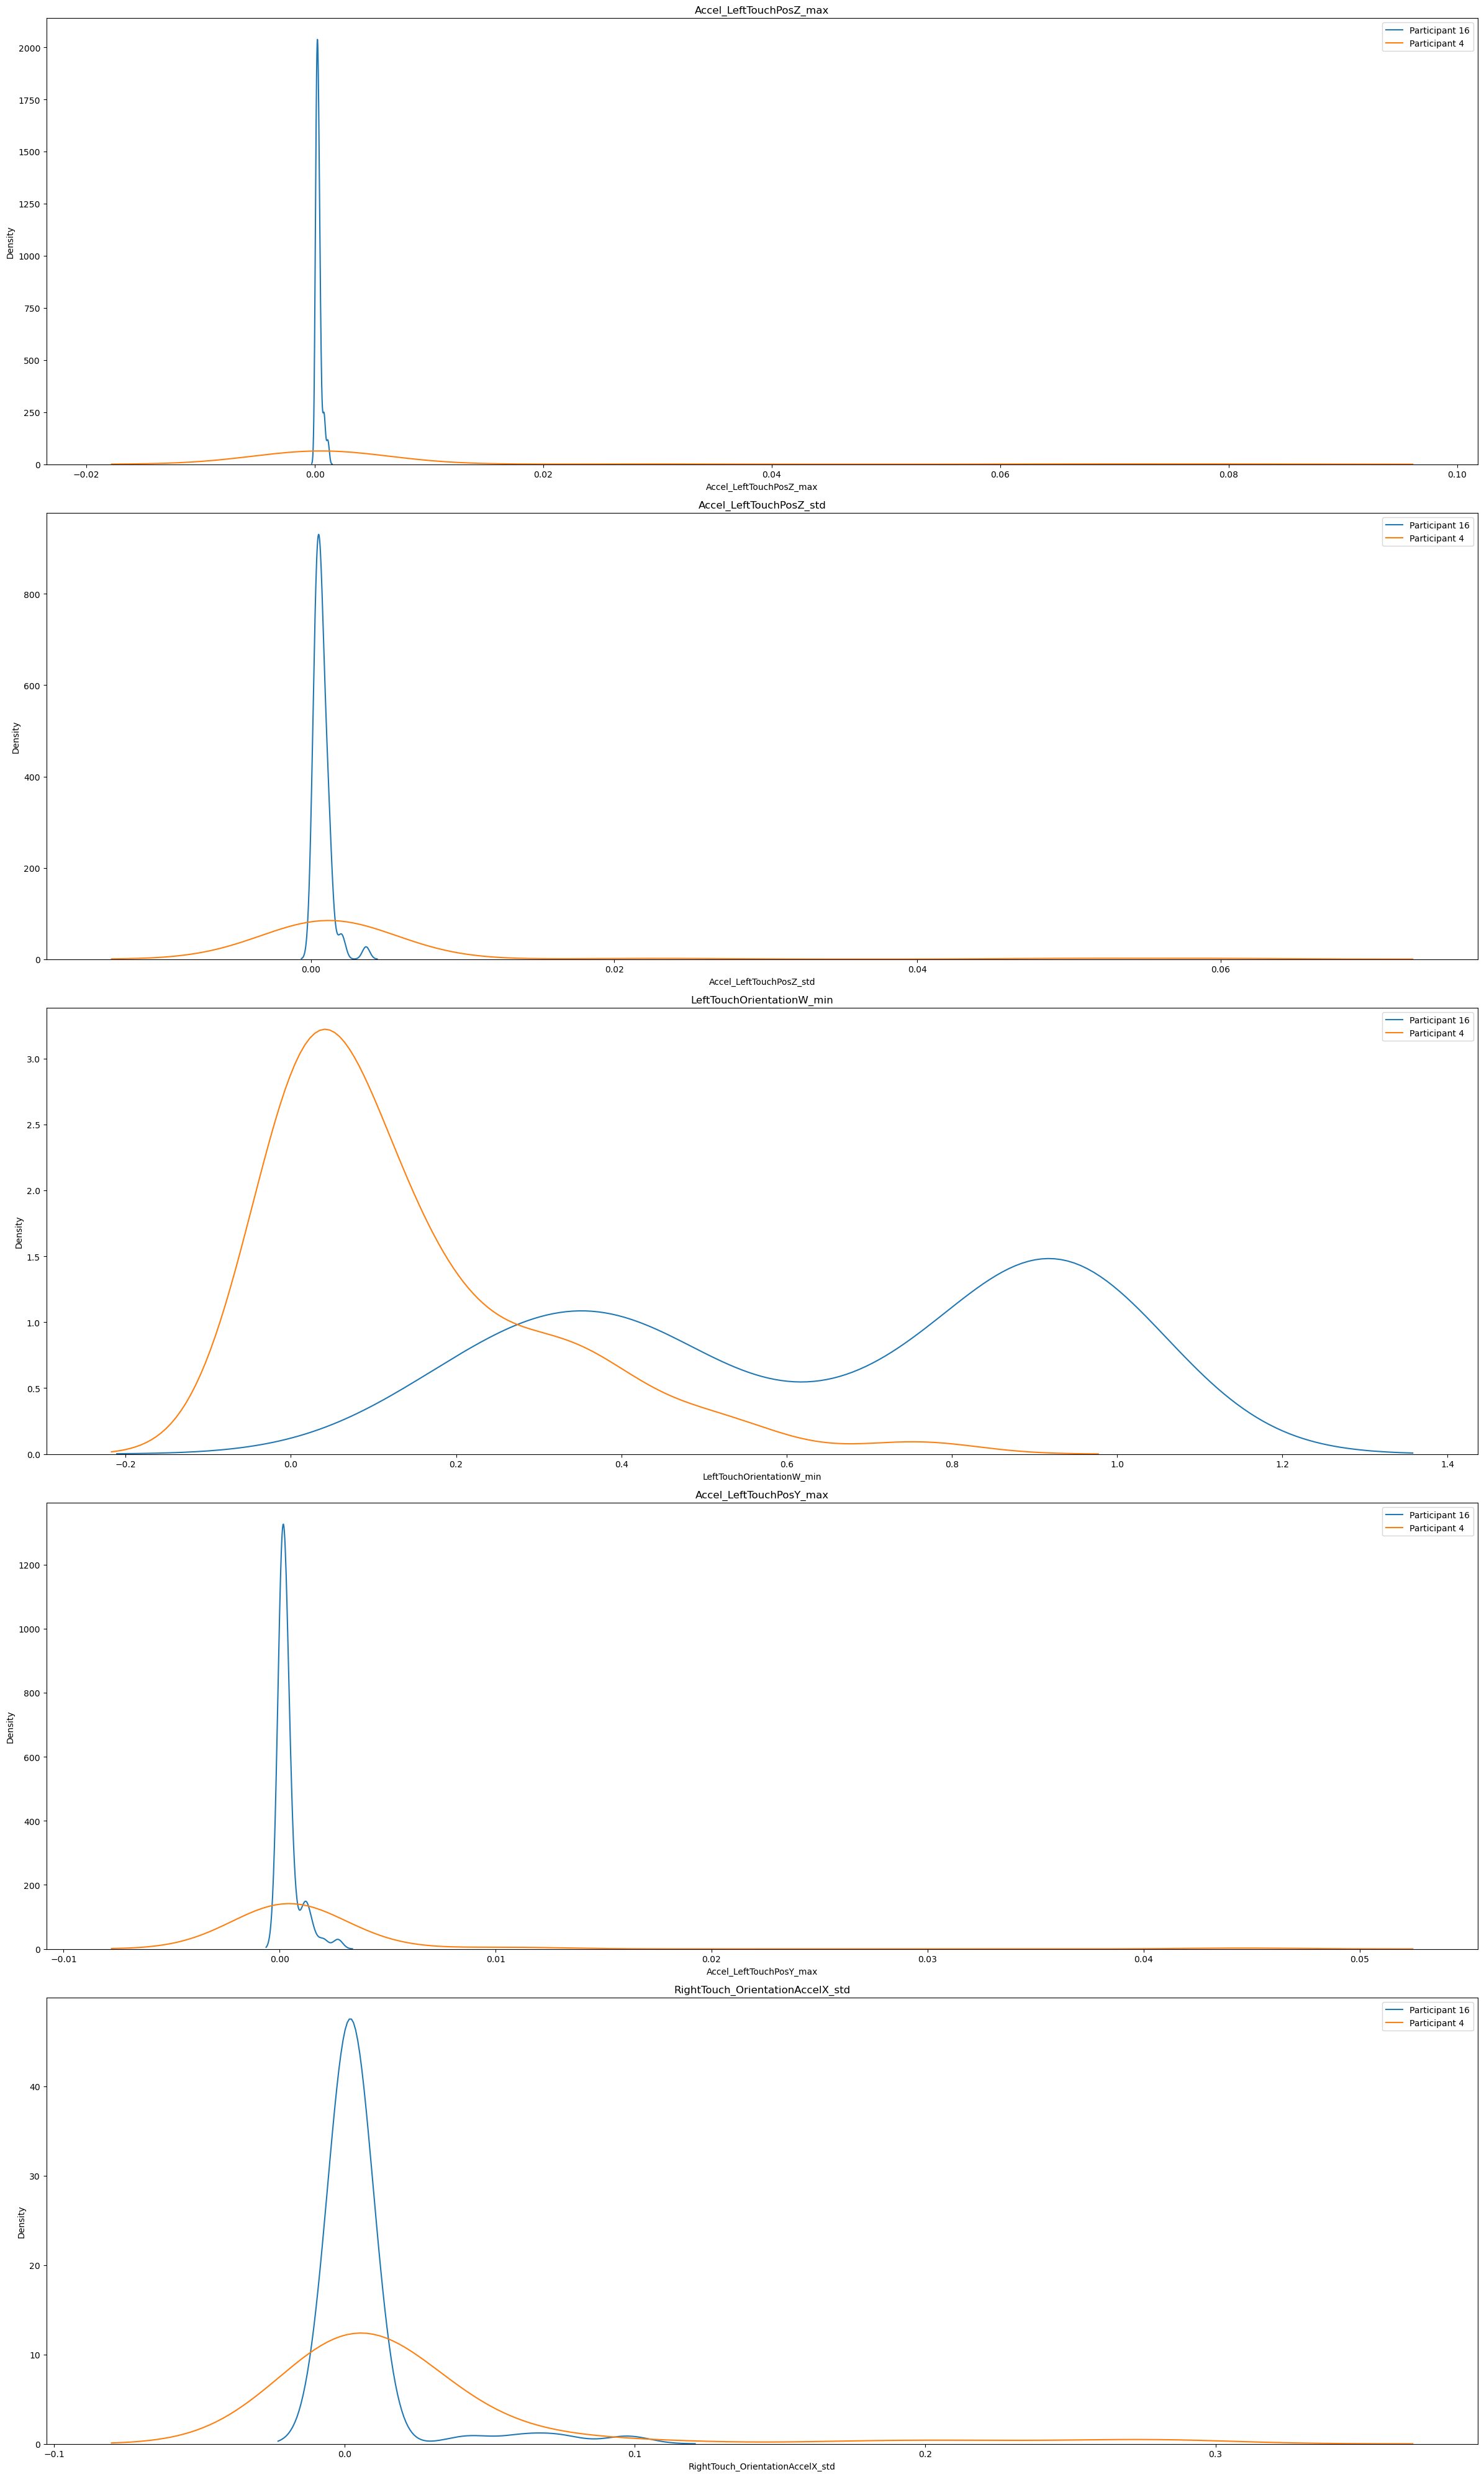

In [14]:
# Visualize feature distributions for top 5 different features
top_5_different_features = most_different_features.head(5).index

fig, axes = plt.subplots(5, 1, figsize=(24, 40))
for i, feature in enumerate(top_5_different_features):
    sns.kdeplot(data=misclassified_data[feature], ax=axes[i], label=f"Participant {misclassified_participant}")
    sns.kdeplot(data=confused_with_data[feature], ax=axes[i], label=f"Participant {confused_with}")
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

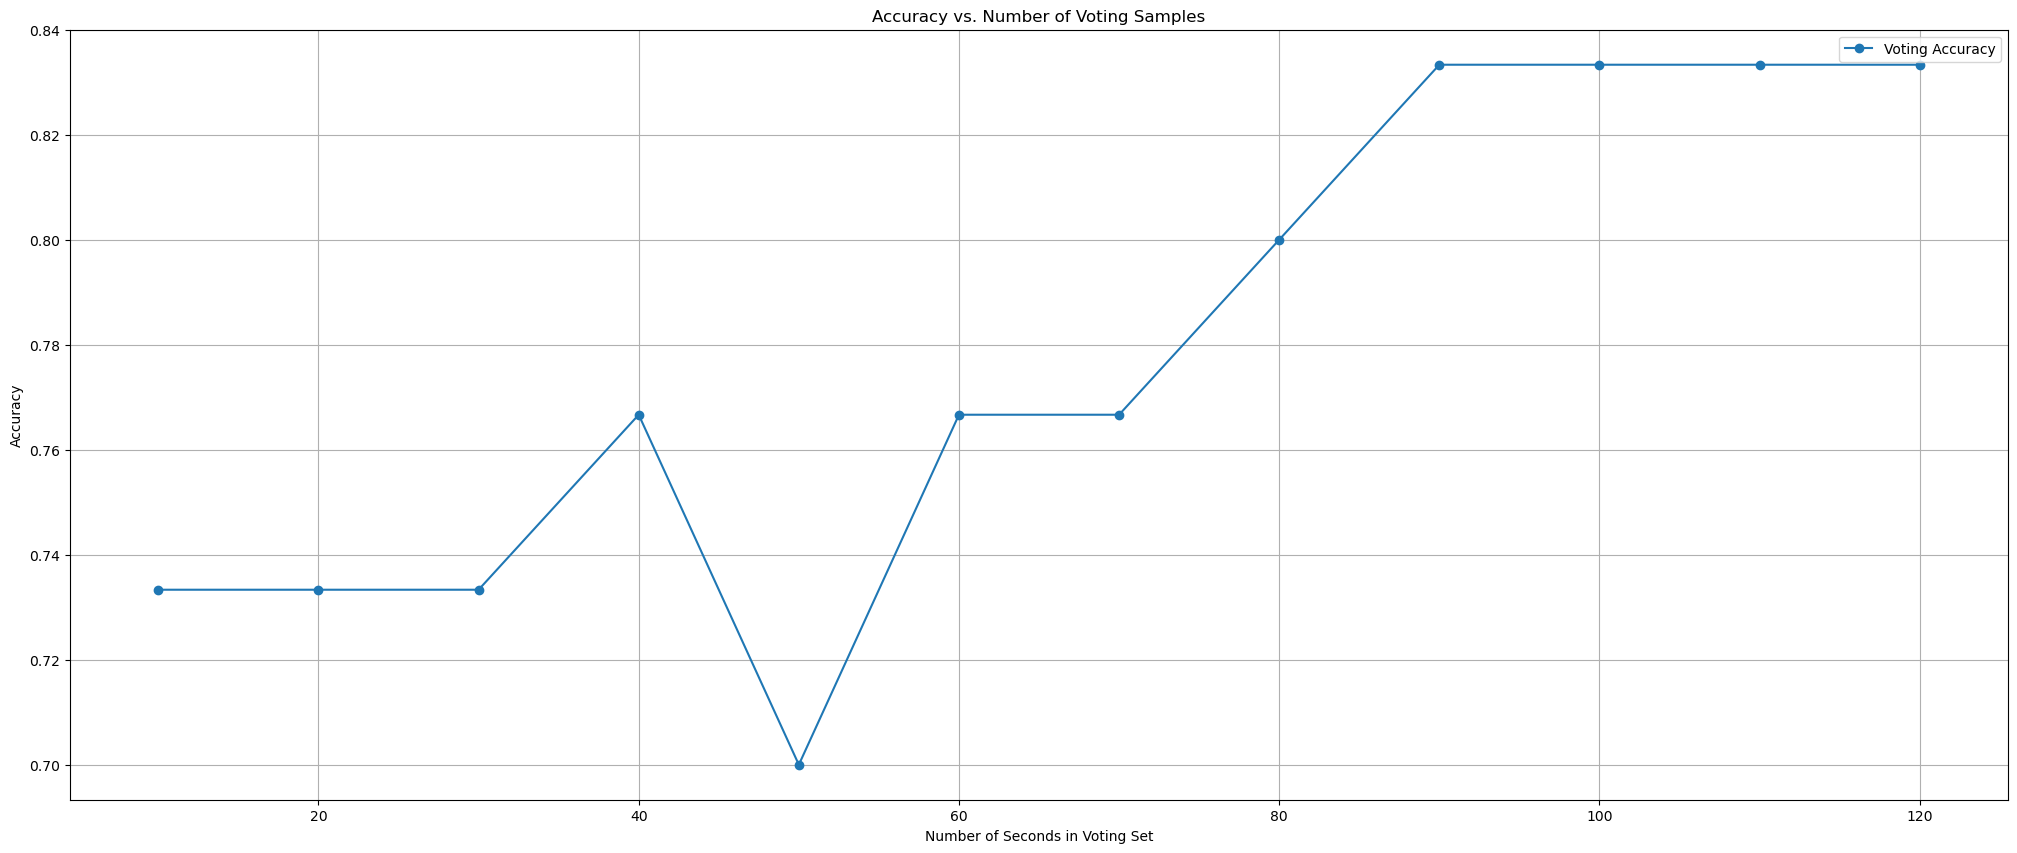


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,0.733333
1,20,0.733333
2,30,0.733333
3,40,0.766667
4,50,0.700000
5,60,0.766667
6,70,0.766667
7,80,0.800000
8,90,0.833333
9,100,0.833333


In [15]:
evaluator.plot_accuracy_by_vote(best_model_slow, X_test, y_test, increment=1)

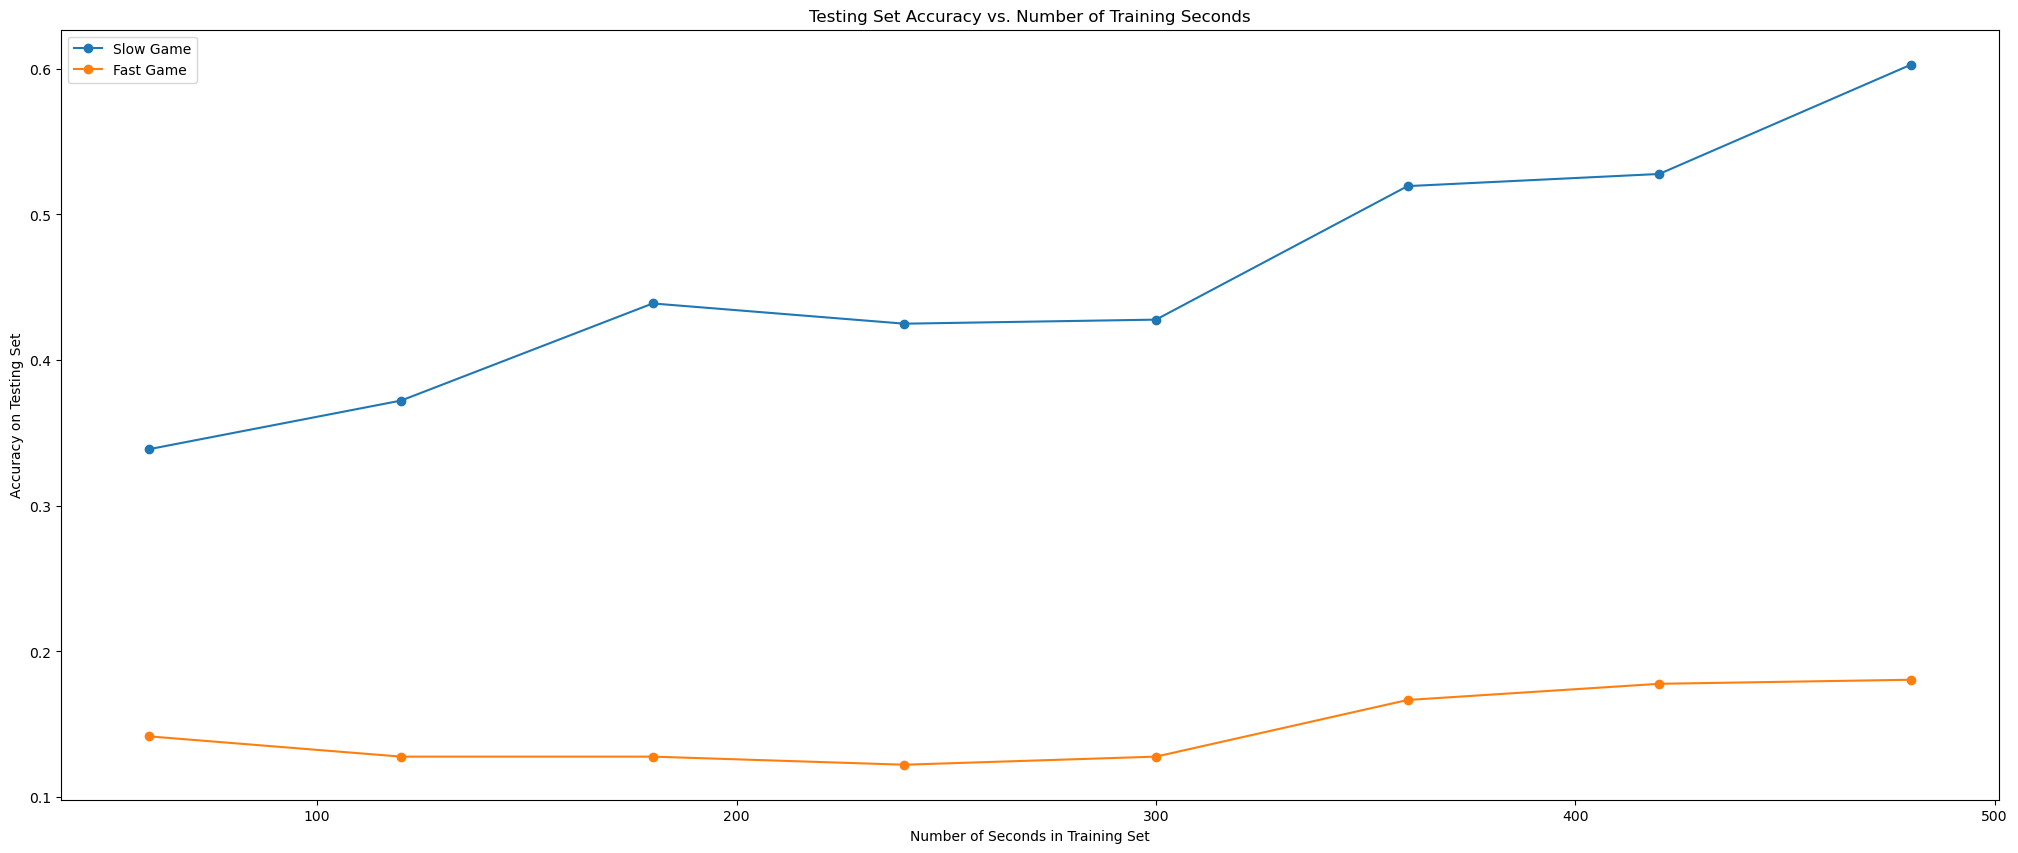


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.338889,0.141667
1,120,0.372222,0.127778
2,180,0.438889,0.127778
3,240,0.425000,0.122222
4,300,0.427778,0.127778
5,360,0.519444,0.166667
6,420,0.527778,0.177778
7,480,0.602778,0.180556


In [16]:
evaluator.accuracy_over_time(X, y,best_model_slow_name, range(1,9), X_test, y_test, fX_test, fy_test)

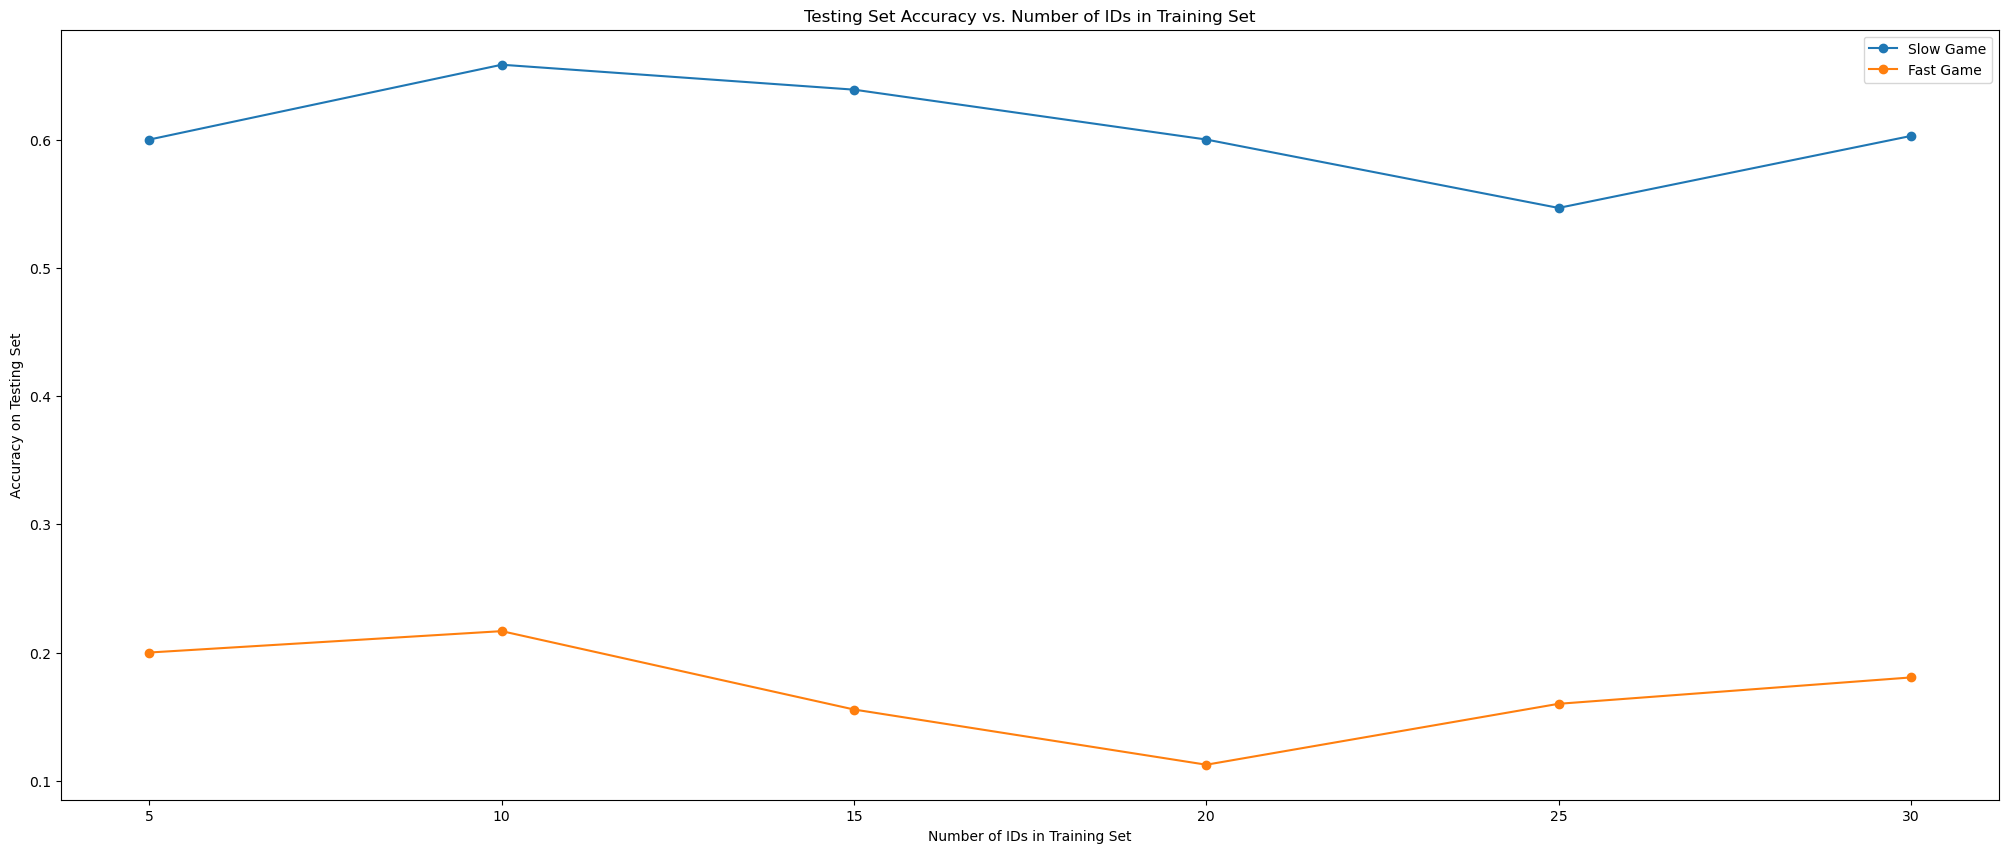


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,0.600000,0.200000
1,10,0.658333,0.216667
2,15,0.638889,0.155556
3,20,0.600000,0.112500
4,25,0.546667,0.160000
5,30,0.602778,0.180556


In [17]:
evaluator.accuracy_over_ids(X_train, y_train, best_model_slow_name,  X_test, y_test,fX_test, fy_test)

### 5.2. Training On Beat Saber

In [18]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast,  best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(fX_train,fy_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Fast)').style.background_gradient(cmap= plt.cm.Blues)

 83%|██████████████████████████████████████████████████████████▎           | 5/6 [00:07<00:01,  1.82s/it]/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),F1(Fast),Precision(Train),Precision(Slow),Precision(Fast),Recall(Train),Recall(Slow),Recall(Fast),Log_loss(Train),Log_loss(Slow),Log_loss(Fast)
3,LogisticRegression,0.543056,0.222222,0.475000,0.497647,0.173352,0.427982,0.565719,0.204468,0.494936,0.543056,0.222222,0.475000,2.108447,2.695026,2.088444
0,ExtraTreesClassifier,1.000000,0.175000,0.627778,1.000000,0.108246,0.596061,1.000000,0.124191,0.685140,1.000000,0.175000,0.627778,0.000000,5.078151,1.232667
2,QuadraticDiscriminantAnalysis,0.993750,0.061111,0.627778,0.993606,0.023106,0.607526,0.994424,0.017843,0.736788,0.993750,0.061111,0.627778,0.092327,33.840986,12.708376
1,RandomForestClassifier,1.000000,0.150000,0.708333,1.000000,0.100310,0.686115,1.000000,0.091322,0.740534,1.000000,0.150000,0.708333,0.169167,12.746488,1.110434
4,LGBMClassifier,1.000000,0.108333,0.772222,1.000000,0.083073,0.773602,1.000000,0.092838,0.807419,1.000000,0.108333,0.772222,0.000042,5.936513,0.978904
5,VotingClassifier,1.000000,0.113889,0.827778,1.000000,0.079031,0.824135,1.000000,0.089179,0.851050,1.000000,0.113889,0.827778,0.218689,3.125623,0.900500


In [19]:
explainer = shap.TreeExplainer(best_model_fast)
shap_values_fast = explainer.shap_values(fX_test)

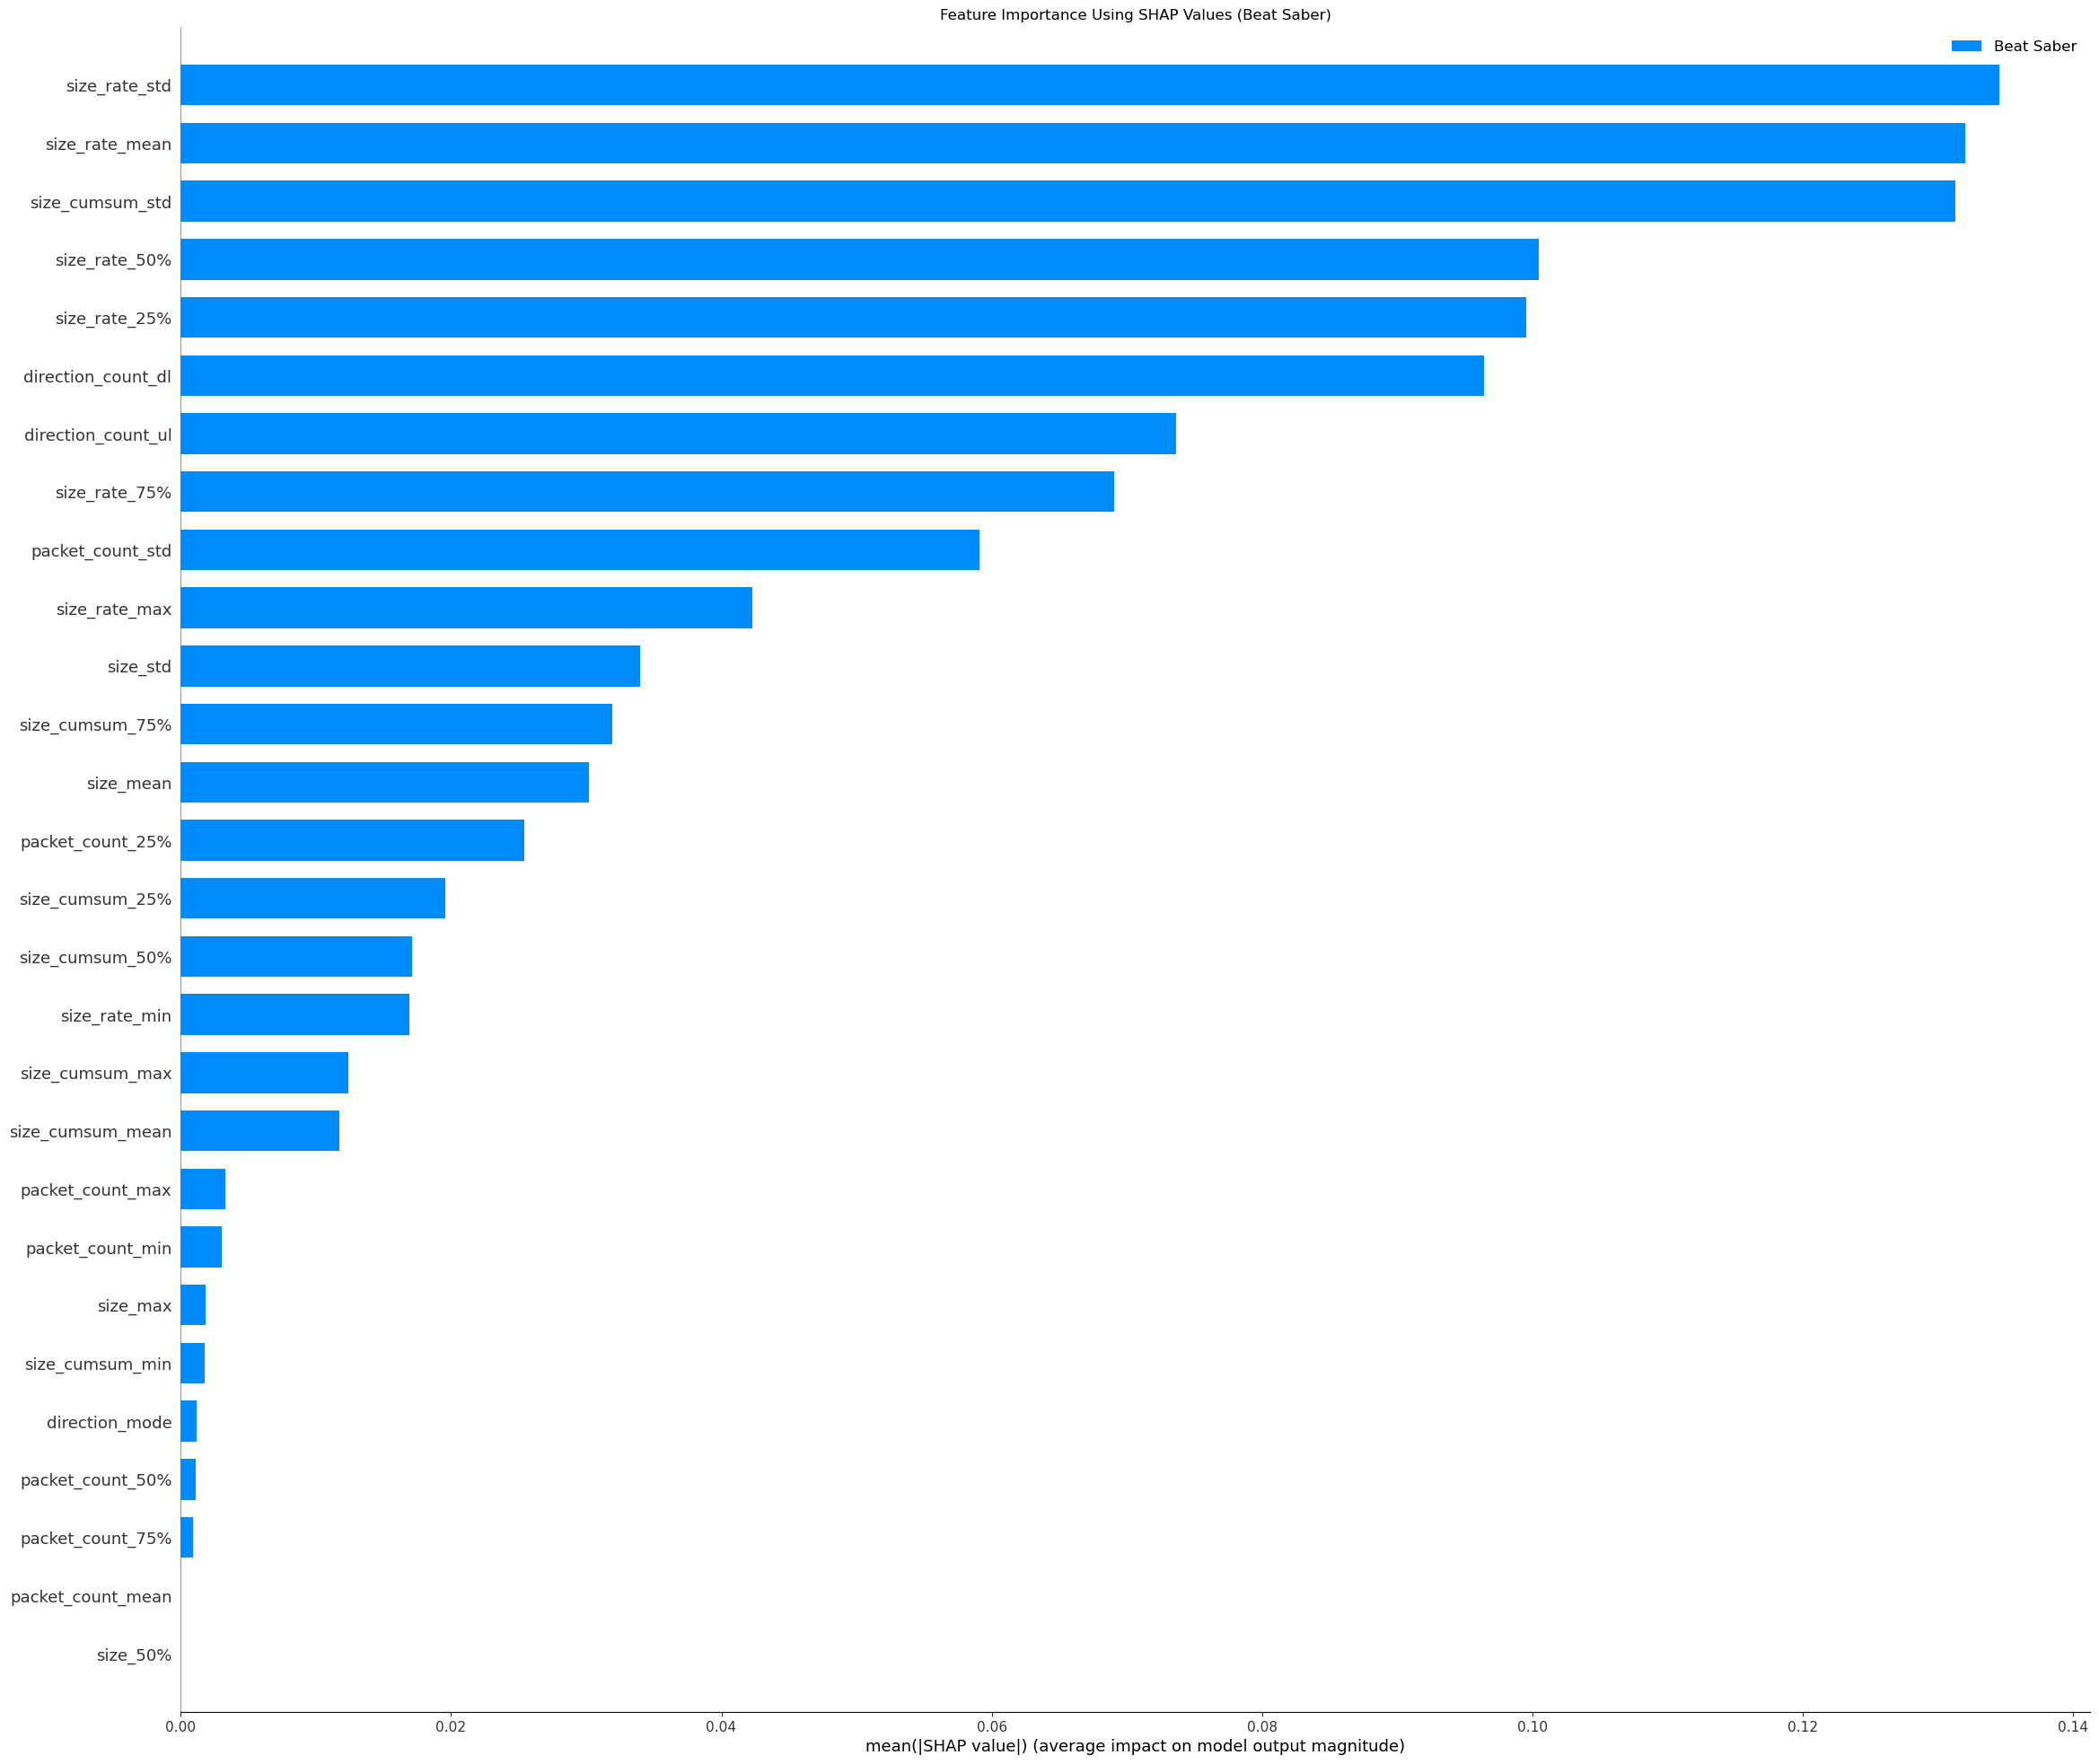

In [20]:
VisualizationUtils.shap_plotter([np.mean(shap_values_fast, axis=2)], 
                          fX_test, title="Feature Importance Using SHAP Values (Beat Saber)",
                          class_names=['Beat Saber'])

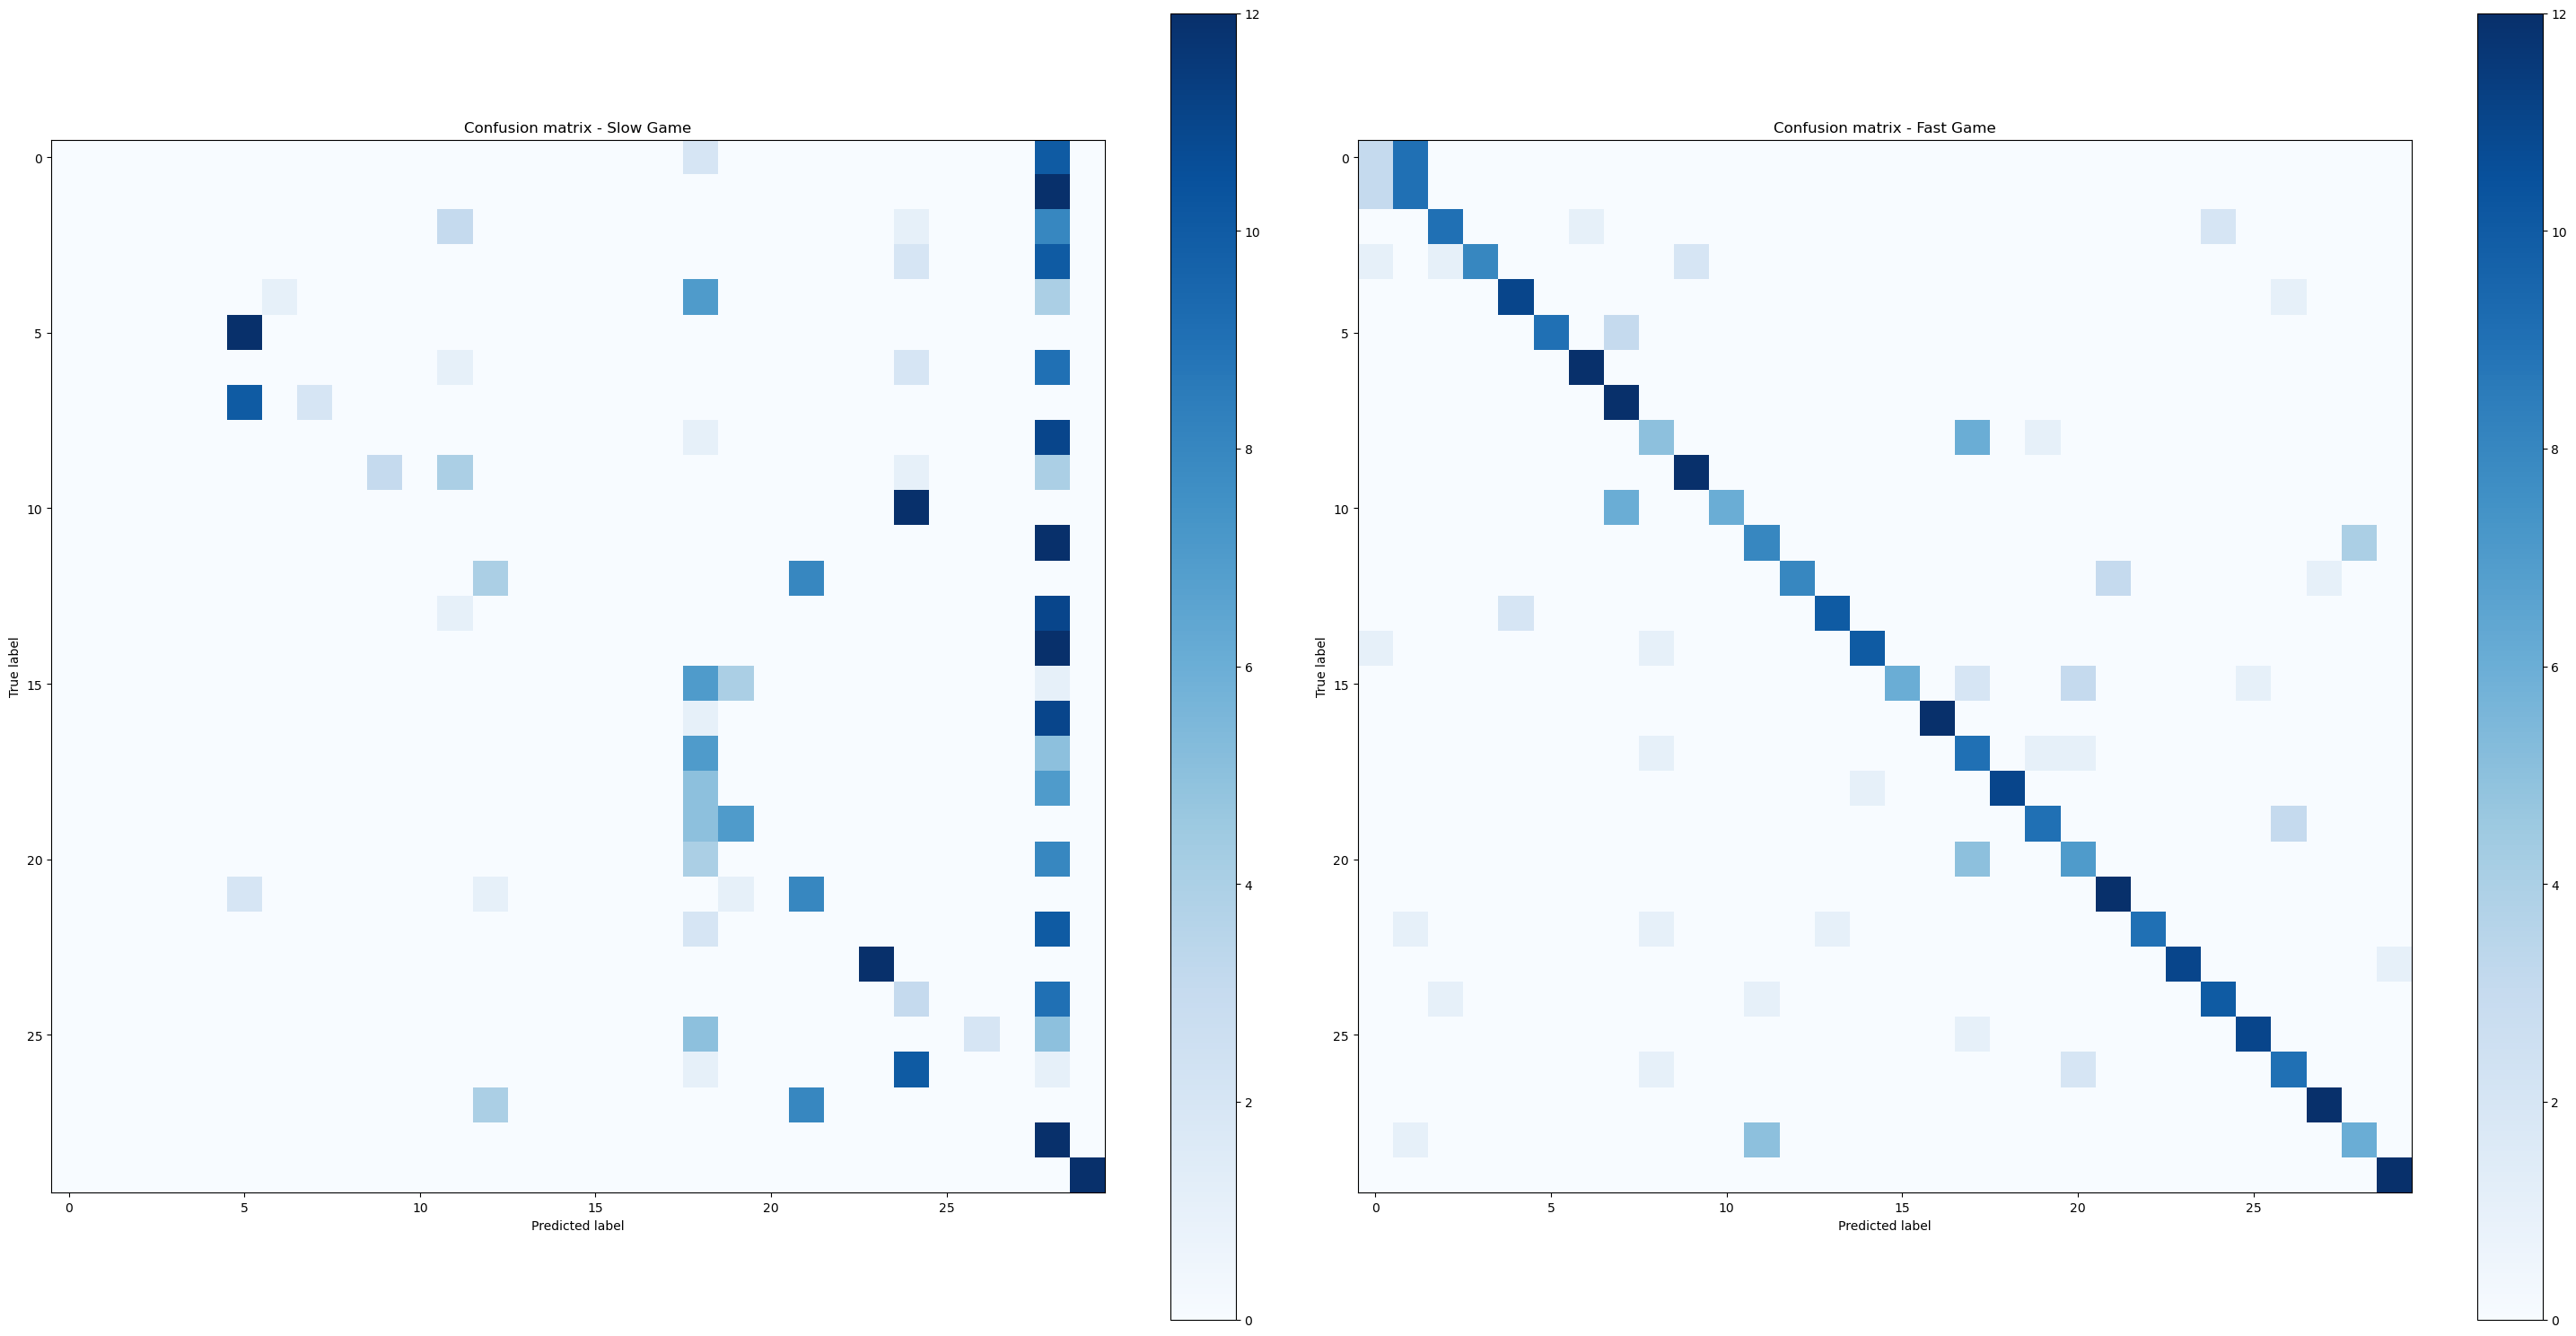

In [21]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

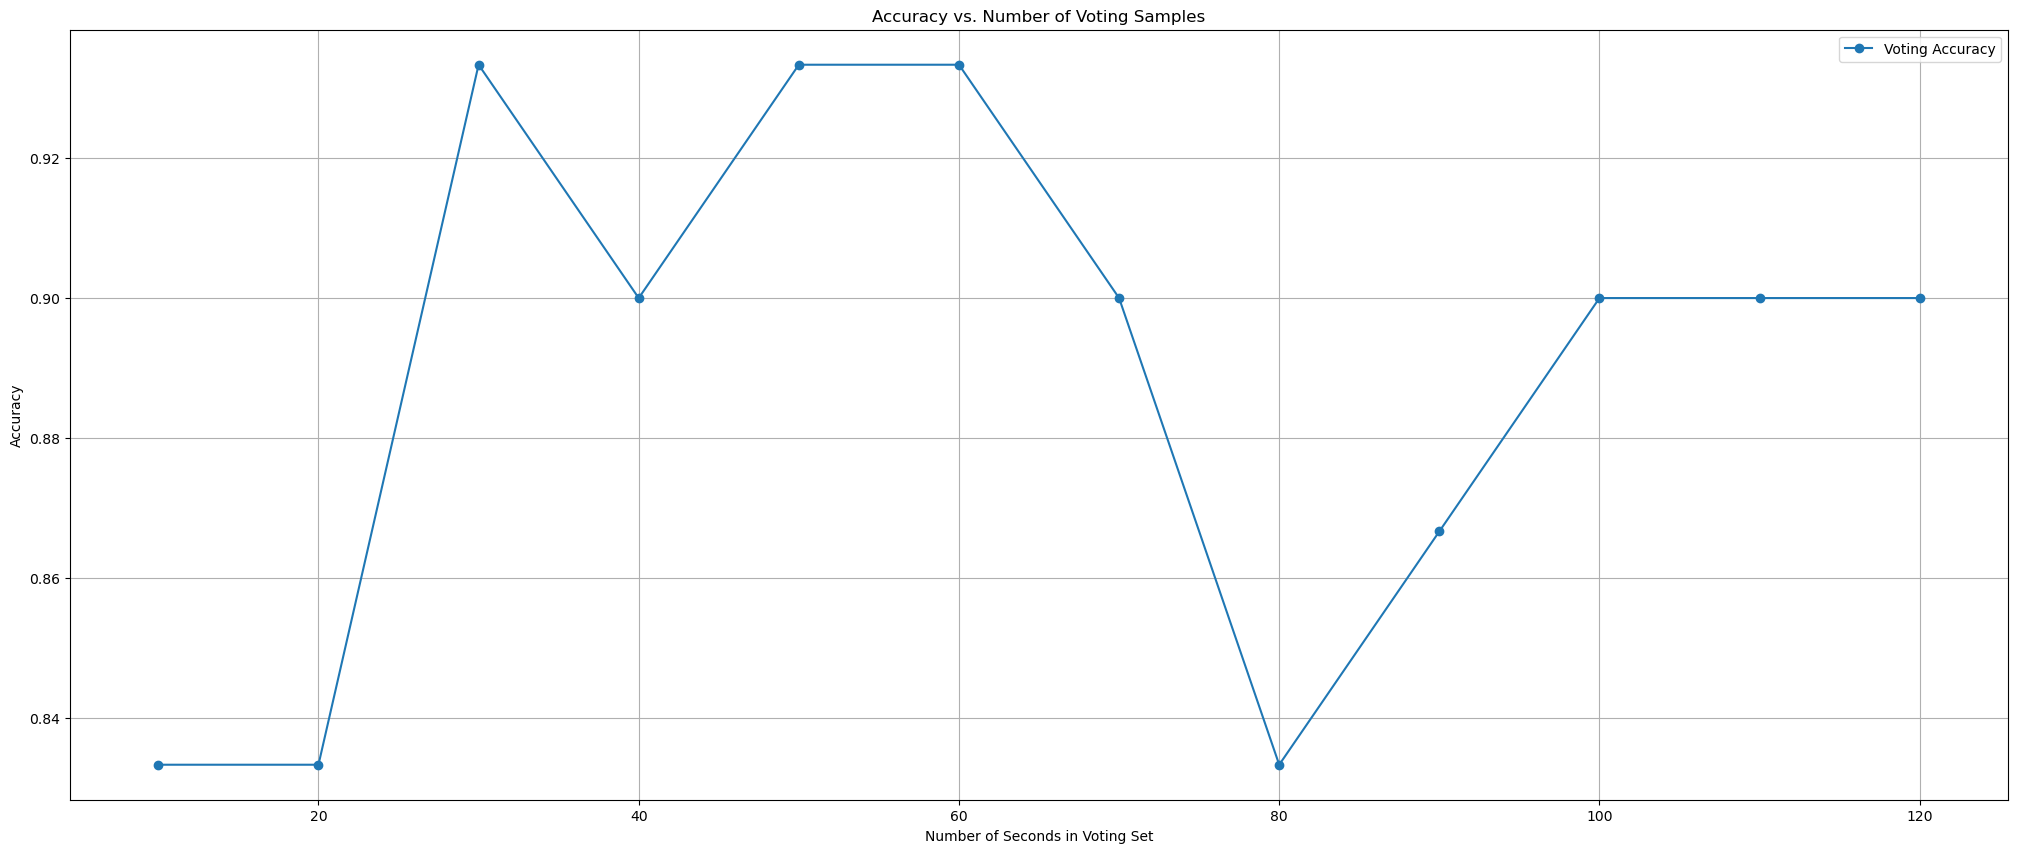


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,0.833333
1,20,0.833333
2,30,0.933333
3,40,0.900000
4,50,0.933333
5,60,0.933333
6,70,0.900000
7,80,0.833333
8,90,0.866667
9,100,0.900000


In [22]:
evaluator.plot_accuracy_by_vote(best_model_fast, fX_test, fy_test, increment=1)

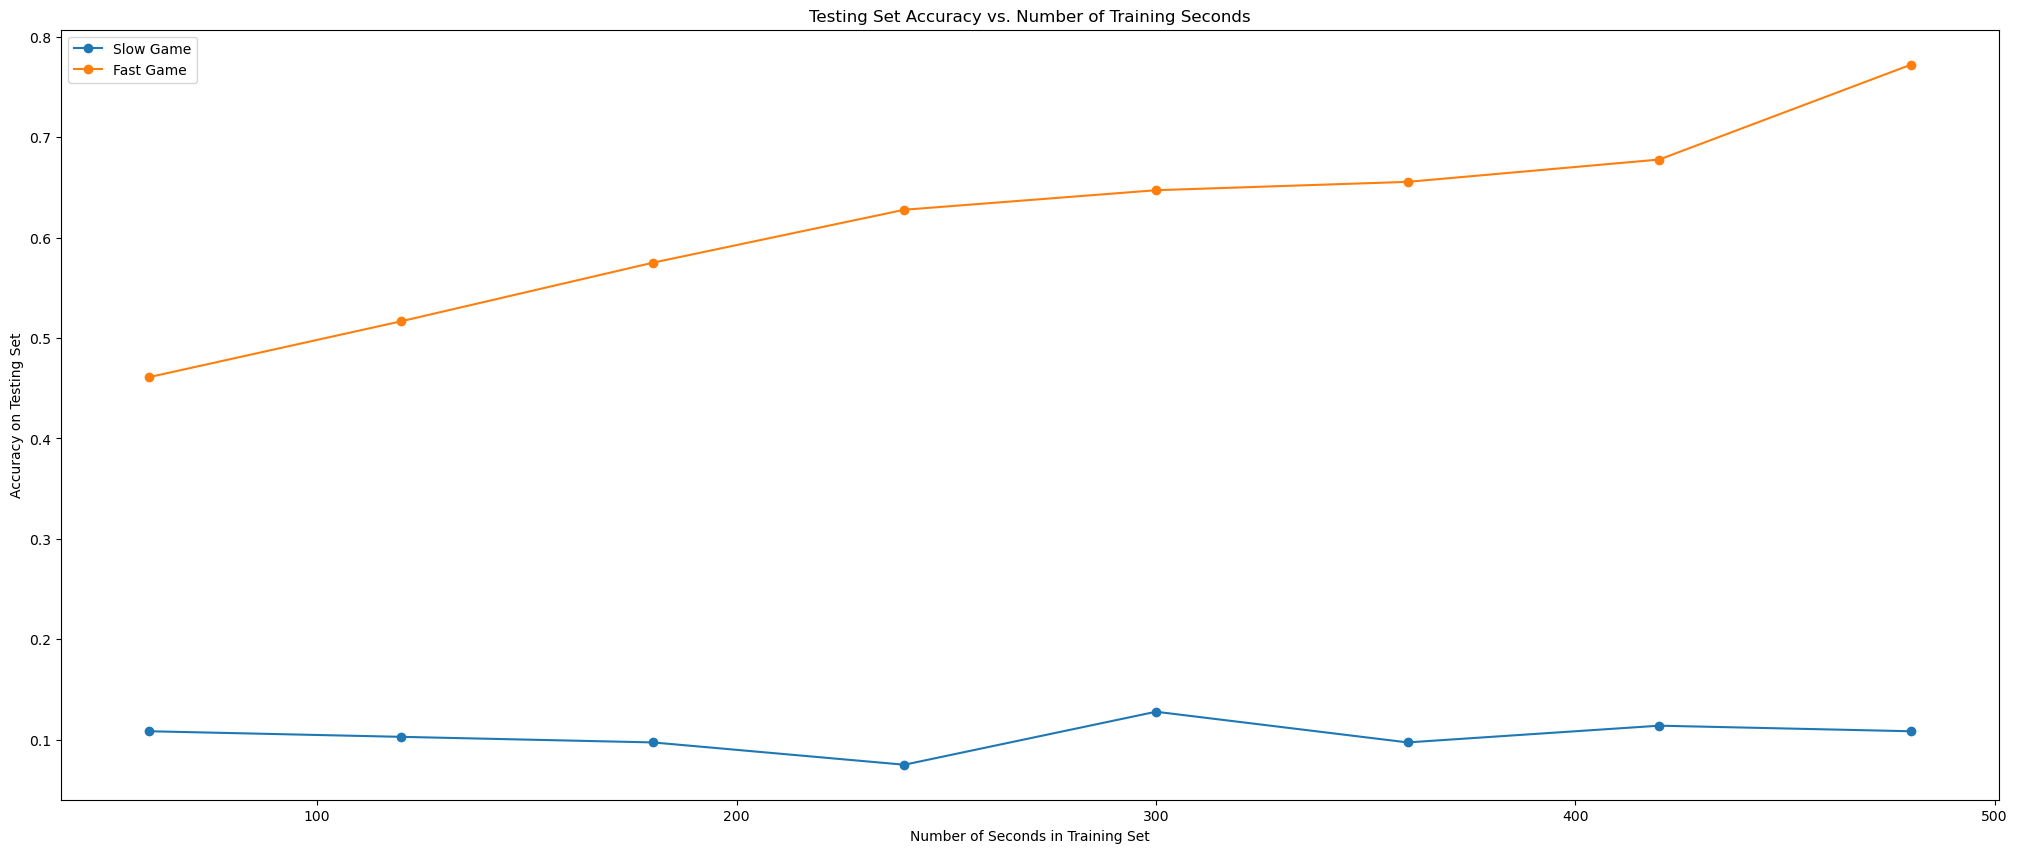


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.108333,0.461111
1,120,0.102778,0.516667
2,180,0.097222,0.575000
3,240,0.075000,0.627778
4,300,0.127778,0.647222
5,360,0.097222,0.655556
6,420,0.113889,0.677778
7,480,0.108333,0.772222


In [23]:
evaluator.accuracy_over_time(fX, fy, best_model_fast_name, range(1,9), X_test, y_test, fX_test, fy_test)

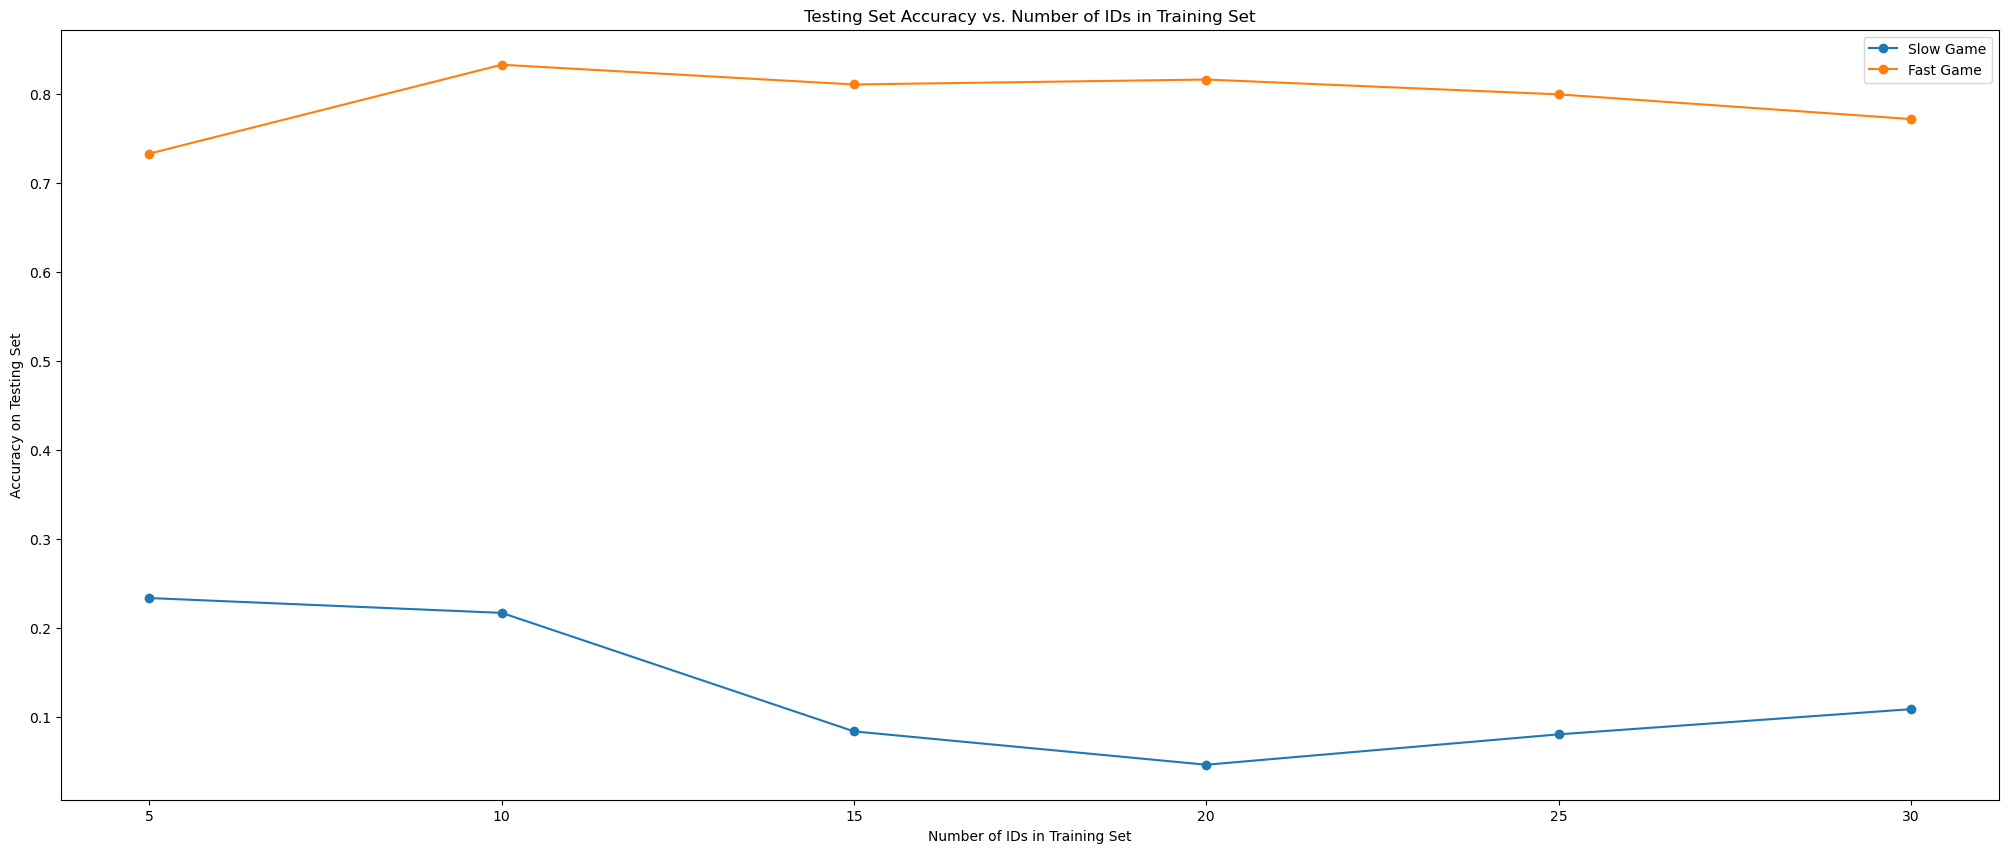


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,0.233333,0.733333
1,10,0.216667,0.833333
2,15,0.083333,0.811111
3,20,0.045833,0.816667
4,25,0.080000,0.800000
5,30,0.108333,0.772222


In [24]:
evaluator.accuracy_over_ids(fX_train, fy_train, best_model_fast_name, X_test, y_test,fX_test, fy_test)

### 5.3. Training On Forklift Simulator

In [25]:
X, y, fX, fy, X_train, y_train, X_test, y_test, fX_train, fy_train, fX_test, fy_test = evaluator.split_data(mov_slow, mov_fast, id_range=range(30,60), train_minutes=8, test_minutes=2)

Size of the training set:  (1440, 462)
Size of the slow testing set:  (360, 462)
Size of the fast training set:  (1440, 462)
Size of the fast testing set:  (360, 462)


In [26]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(X_train,y_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Slow)').style.background_gradient(cmap= plt.cm.Blues)

 83%|██████████████████████████████████████████████████████████▎           | 5/6 [00:17<00:04,  4.98s/it]/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:33<00:00,  5.63s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),F1(Fast),Precision(Train),Precision(Slow),Precision(Fast),Recall(Train),Recall(Slow),Recall(Fast),Log_loss(Train),Log_loss(Slow),Log_loss(Fast)
2,QuadraticDiscriminantAnalysis,1.000000,0.133333,0.030556,1.000000,0.135289,0.027233,1.000000,0.171047,0.036040,1.000000,0.133333,0.030556,0.000000,31.237833,34.942320
4,LGBMClassifier,1.000000,0.938889,0.033333,1.000000,0.938497,0.012406,1.000000,0.946477,0.007670,1.000000,0.938889,0.033333,0.000018,0.241381,11.560417
3,LogisticRegression,0.977083,0.950000,0.052778,0.977070,0.950272,0.027433,0.977970,0.960110,0.060813,0.977083,0.950000,0.052778,0.410015,0.436743,7.890206
1,RandomForestClassifier,1.000000,0.975000,0.038889,1.000000,0.973426,0.028413,1.000000,0.979600,0.038758,1.000000,0.975000,0.038889,0.069095,0.341248,15.844995
5,VotingClassifier,1.000000,0.986111,0.027778,1.000000,0.985955,0.018300,1.000000,0.987179,0.014776,1.000000,0.986111,0.027778,0.076091,0.474448,5.243997
0,ExtraTreesClassifier,1.000000,0.997222,0.058333,1.000000,0.997217,0.030330,1.000000,0.997436,0.033788,1.000000,0.997222,0.058333,0.000000,0.336477,6.006862


In [27]:
explainer = shap.TreeExplainer(best_model_slow)
shap_values_slow = explainer.shap_values(X_test)

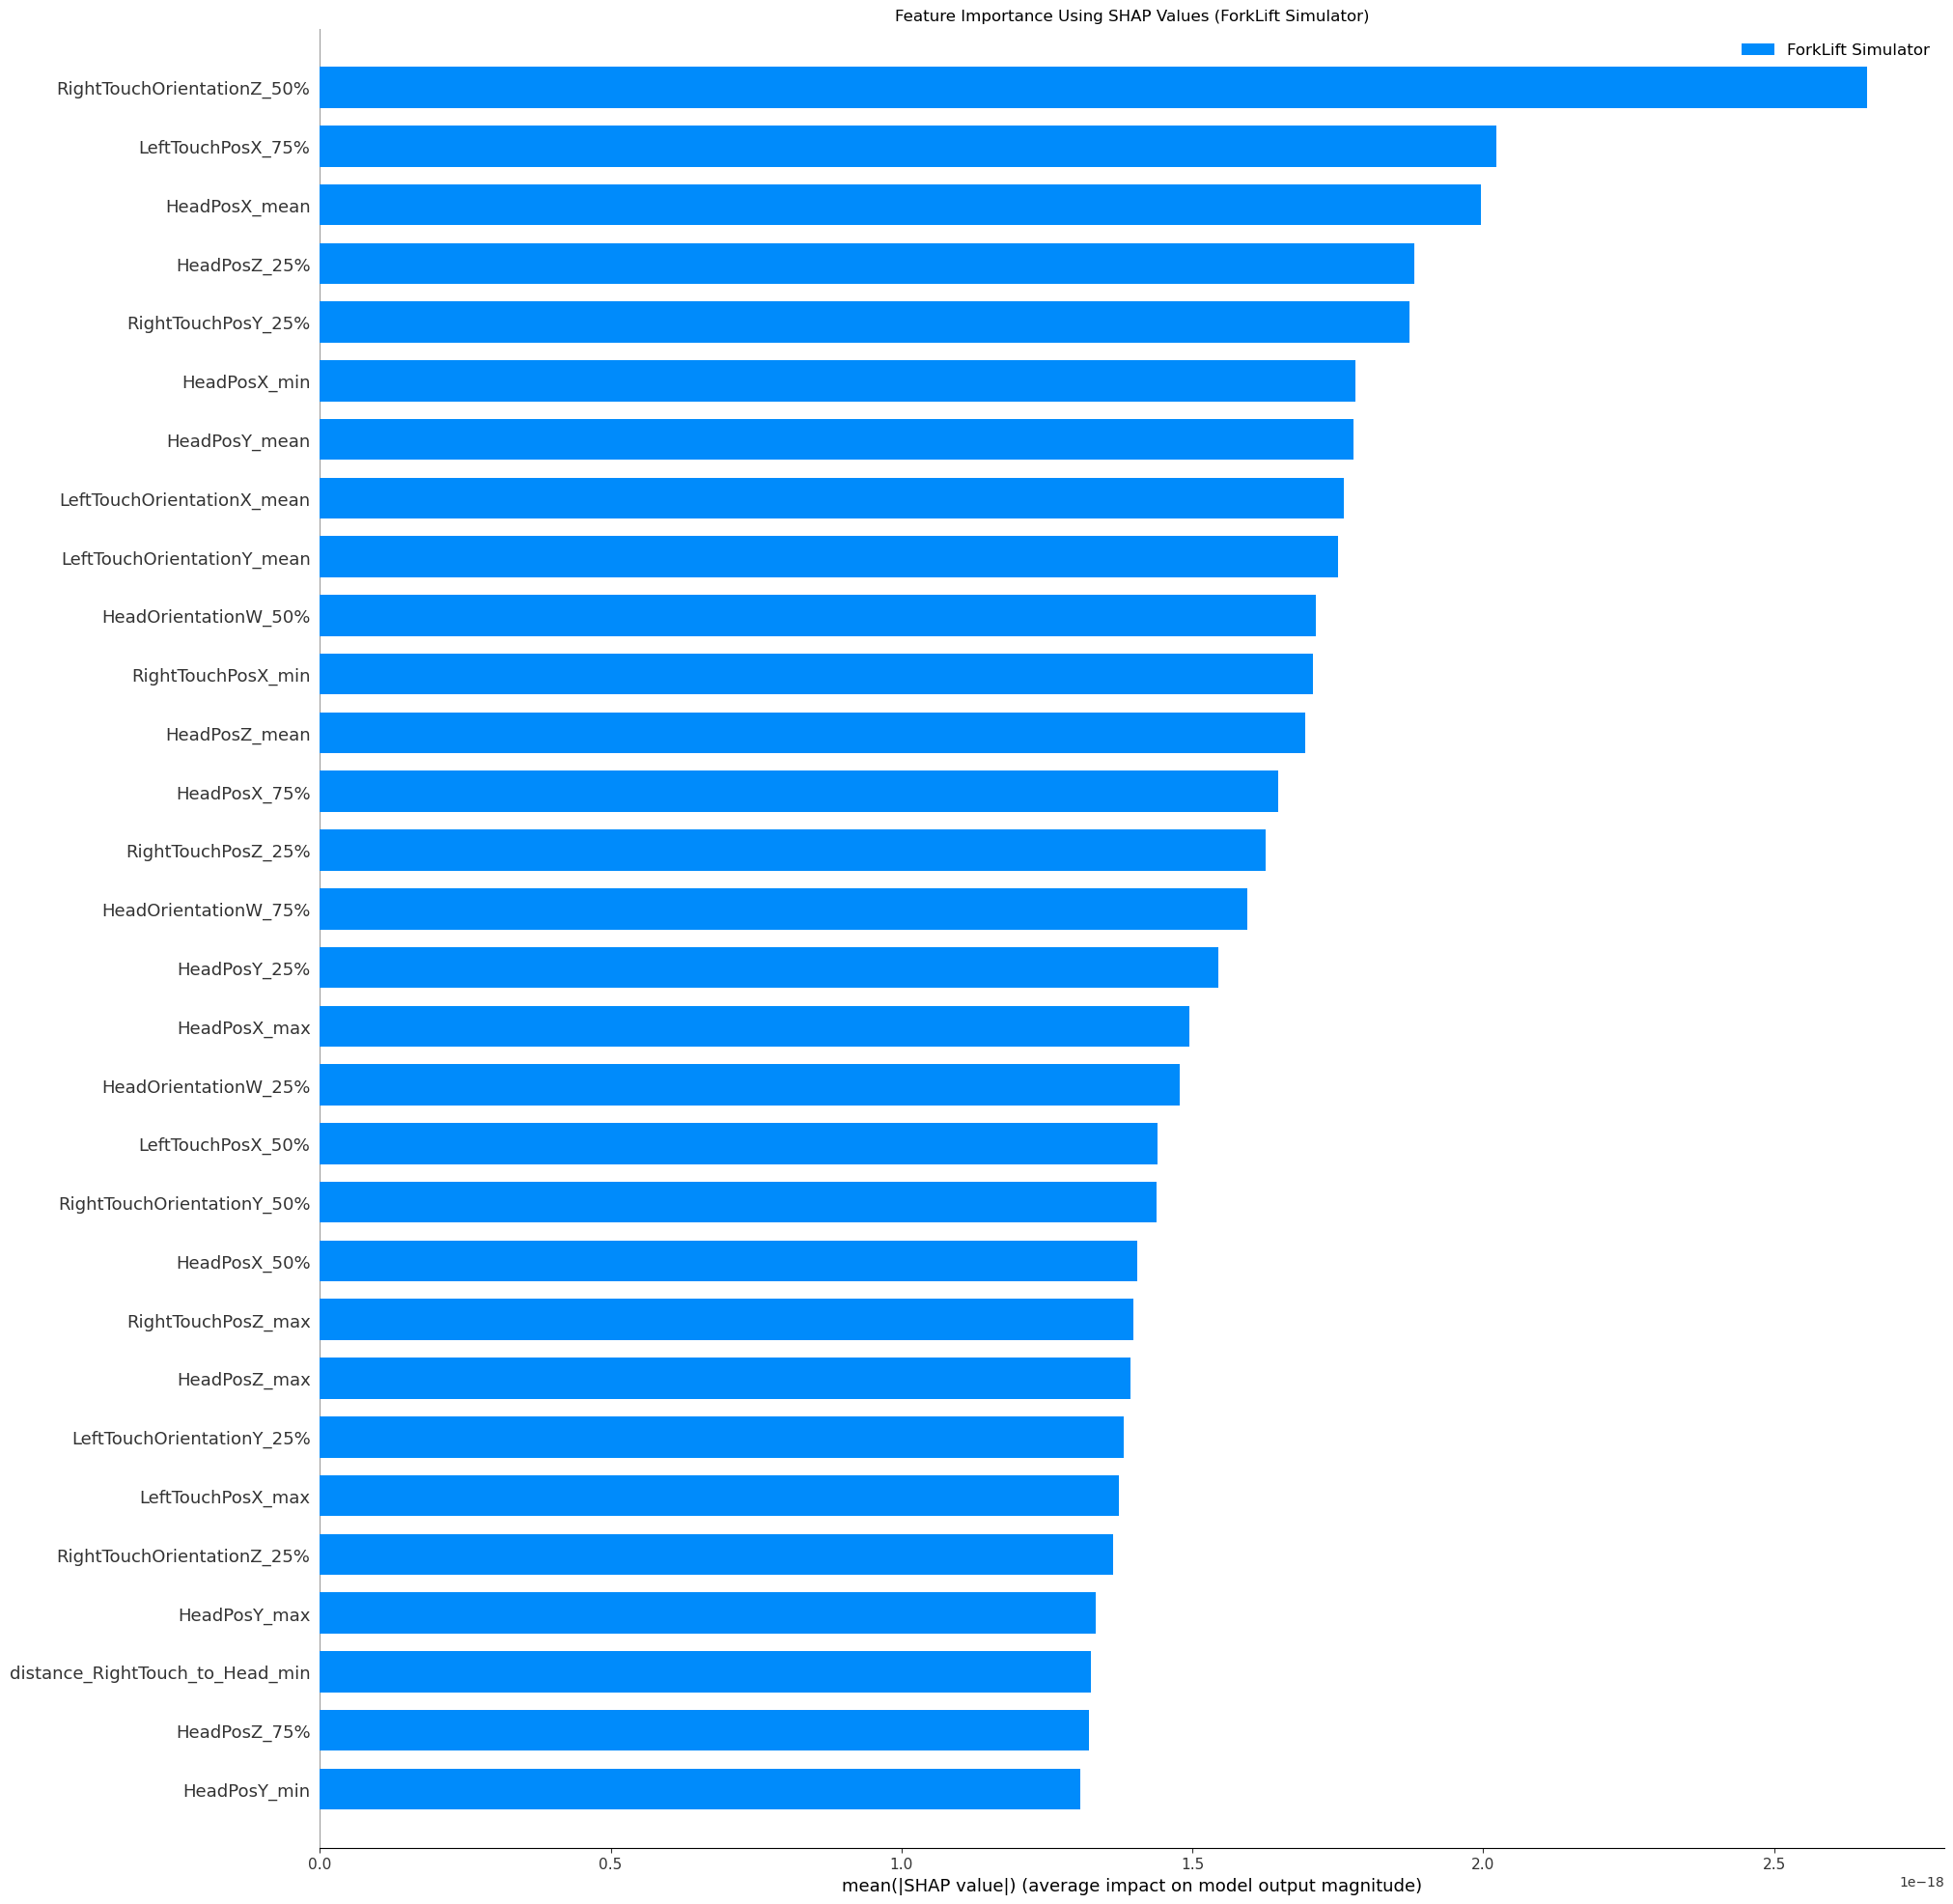

In [28]:
VisualizationUtils.shap_plotter([np.mean(shap_values_slow, axis=2)], 
                          X_test, title="Feature Importance Using SHAP Values (ForkLift Simulator)",
                          class_names=['ForkLift Simulator'])

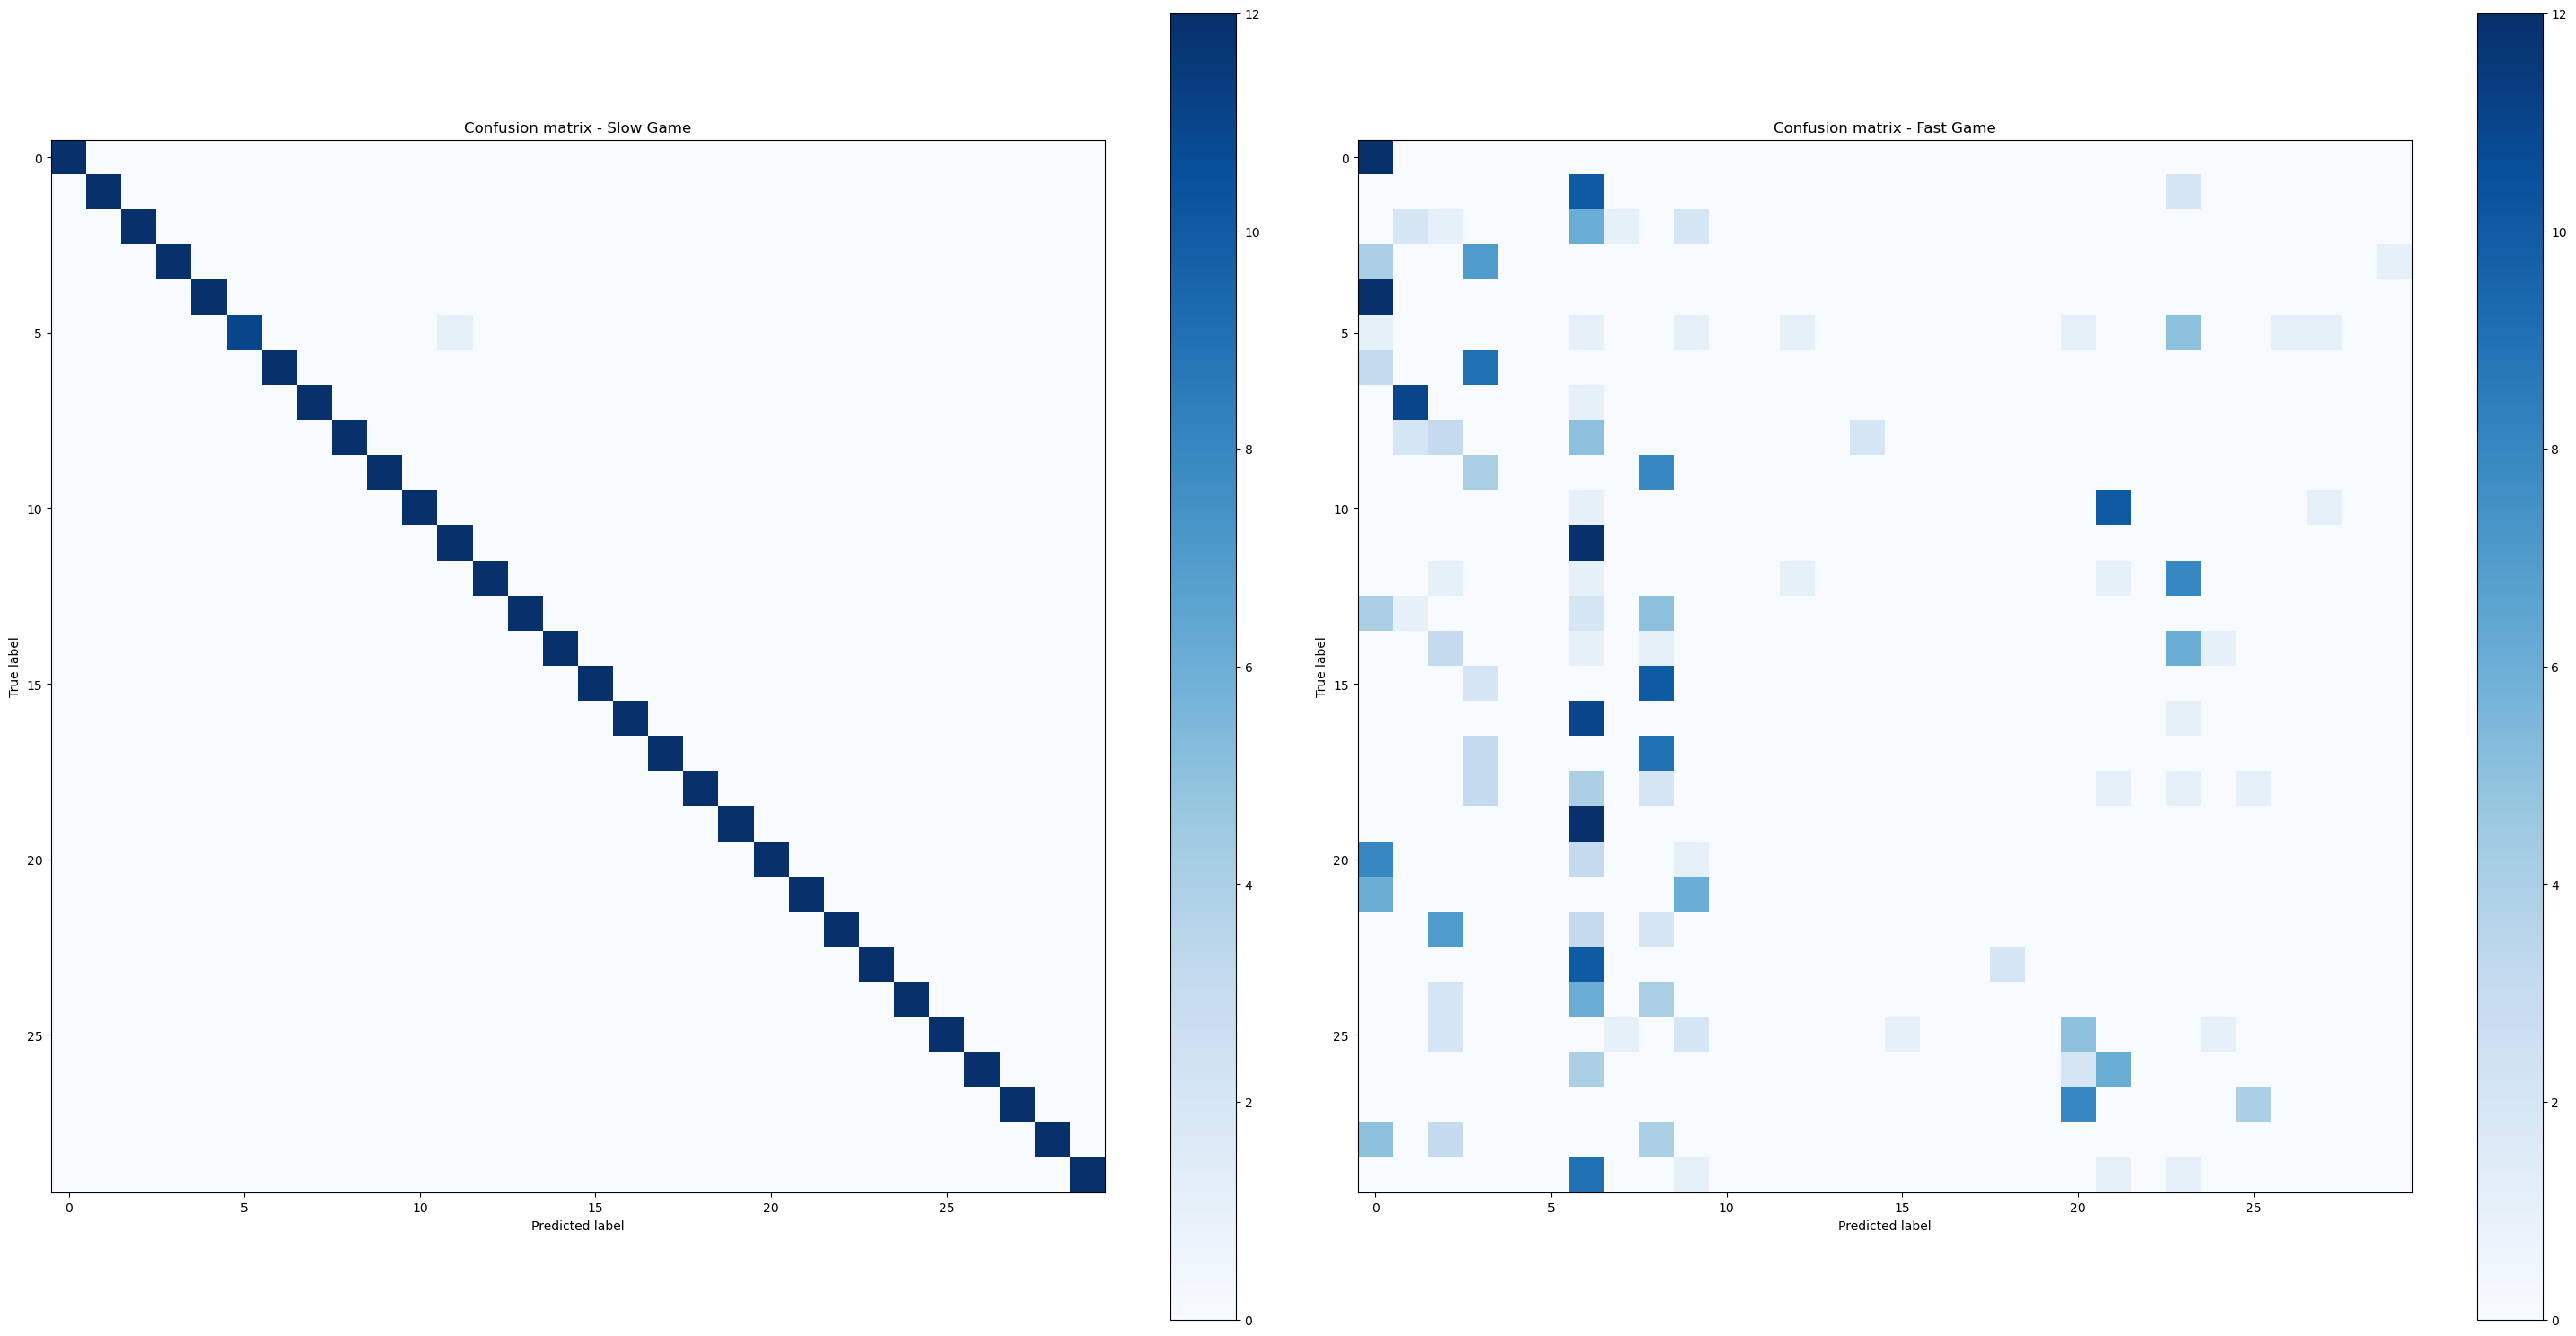

In [29]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

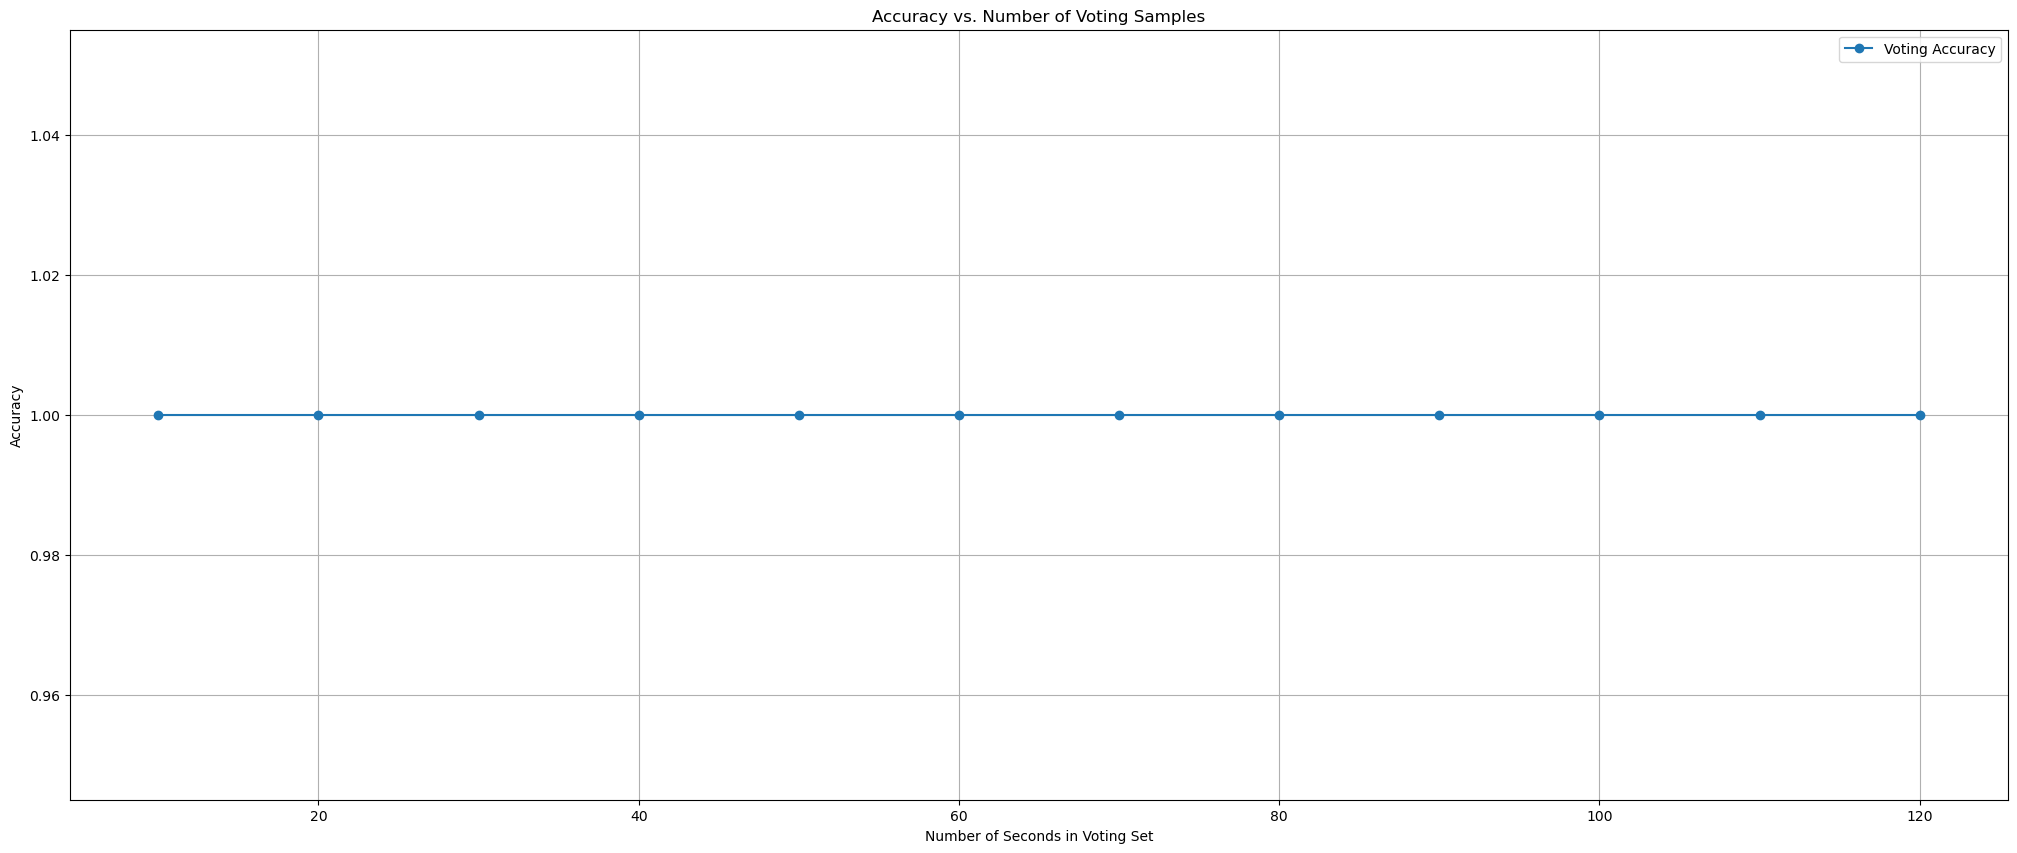


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,1.0
1,20,1.0
2,30,1.0
3,40,1.0
4,50,1.0
5,60,1.0
6,70,1.0
7,80,1.0
8,90,1.0
9,100,1.0


In [30]:
evaluator.plot_accuracy_by_vote(best_model_slow, X_test, y_test, increment=1)

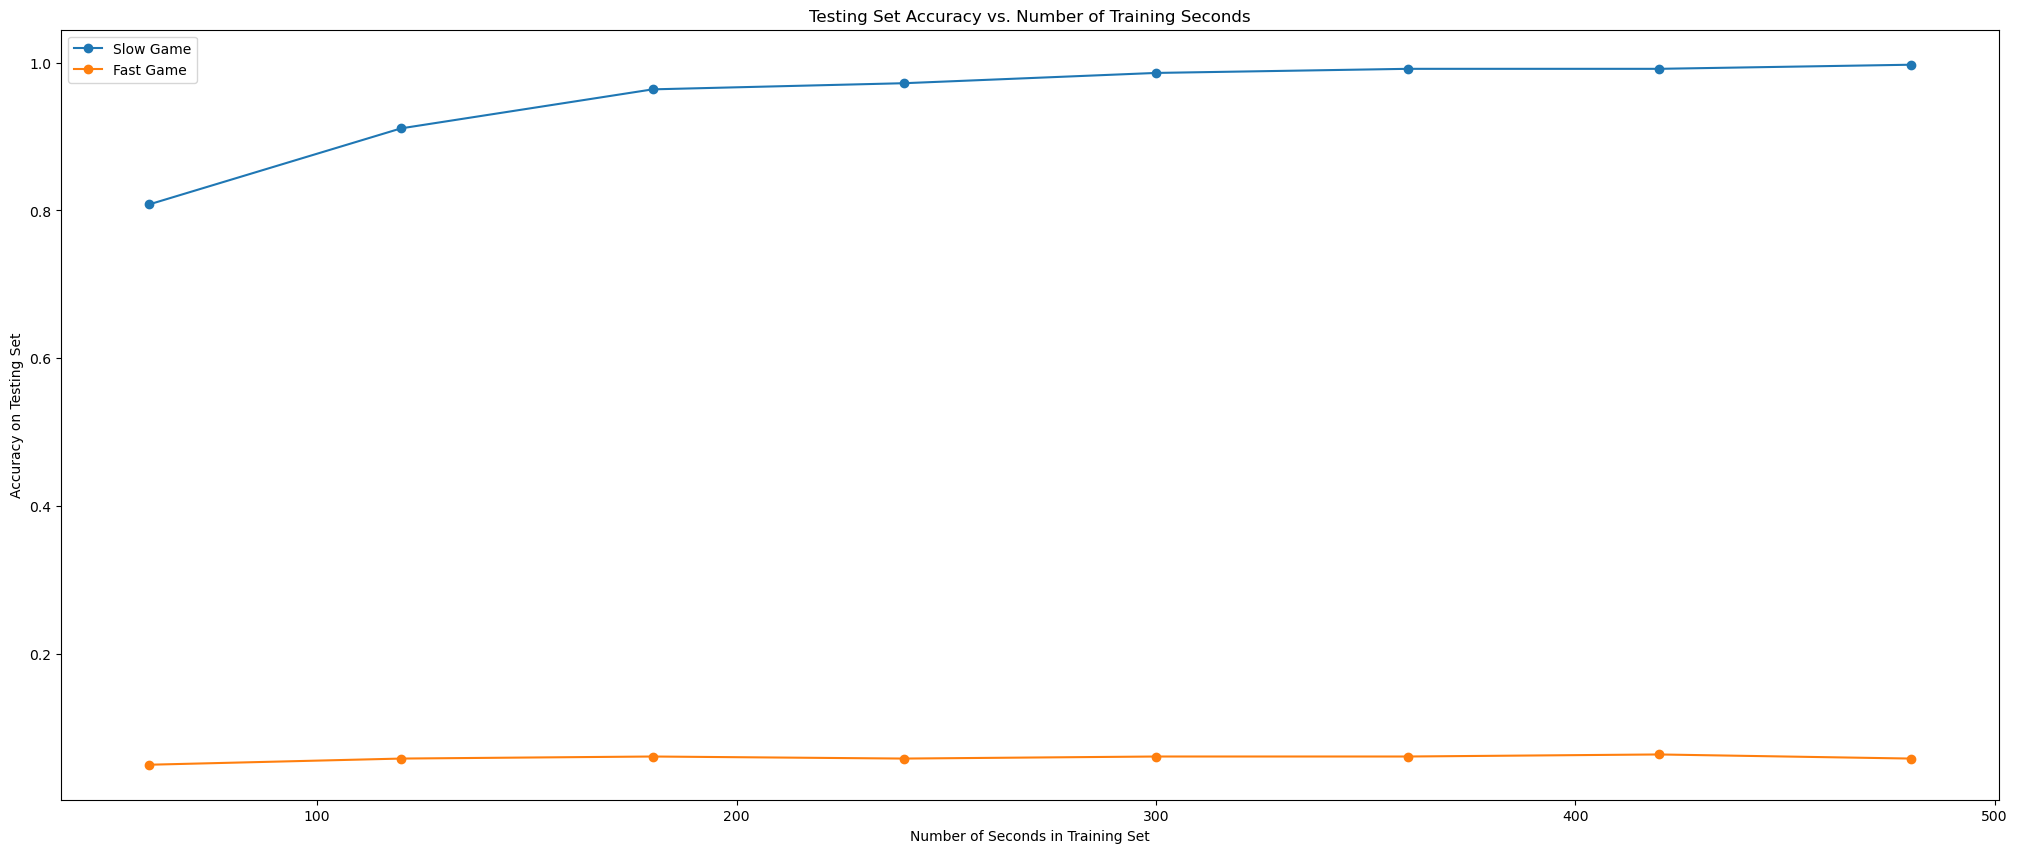


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.808333,0.050000
1,120,0.911111,0.058333
2,180,0.963889,0.061111
3,240,0.972222,0.058333
4,300,0.986111,0.061111
5,360,0.991667,0.061111
6,420,0.991667,0.063889
7,480,0.997222,0.058333


In [31]:
evaluator.accuracy_over_time(X, y,best_model_slow_name, range(1,9), X_test, y_test, fX_test, fy_test)

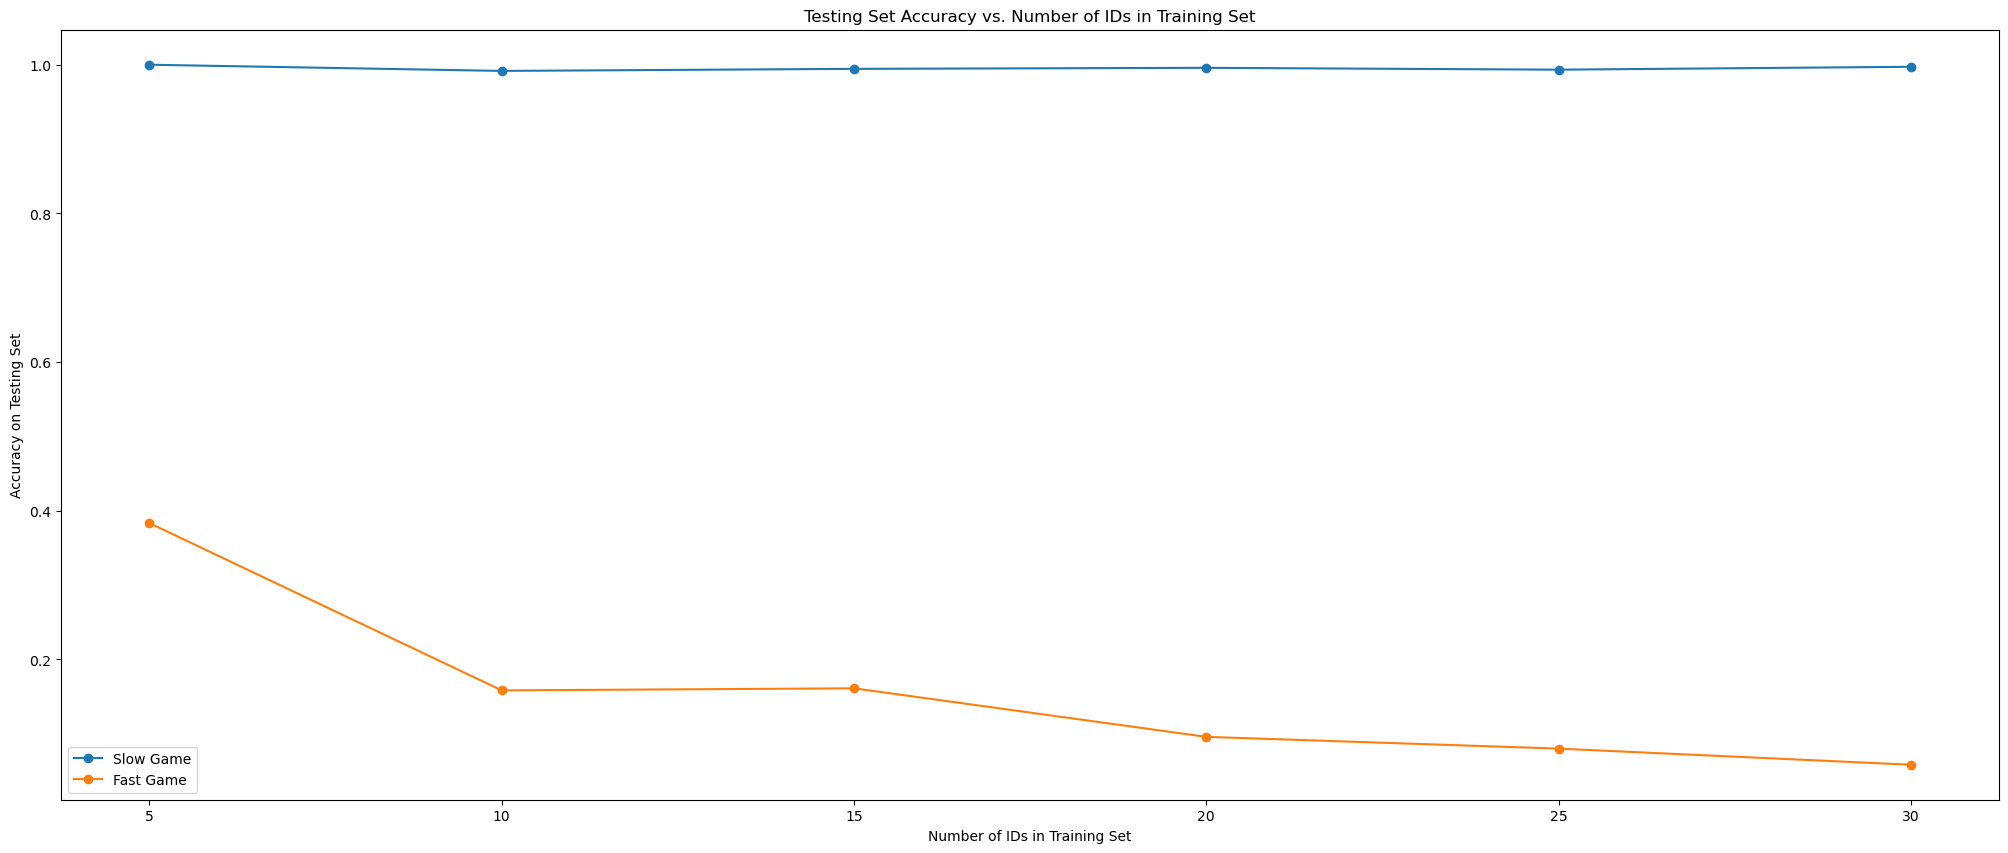


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,1.000000,0.383333
1,10,0.991667,0.158333
2,15,0.994444,0.161111
3,20,0.995833,0.095833
4,25,0.993333,0.080000
5,30,0.997222,0.058333


In [32]:
evaluator.accuracy_over_ids(X_train, y_train,best_model_slow_name, X_test, y_test,fX_test, fy_test)

### 5.4. Training On Medal of Honor

In [33]:
Accuracy_set, models, best_model_slow, best_model_fast, cm_slow, cm_fast, best_model_slow_name, best_model_fast_name = evaluator.evaluate_classifiers(fX_train,fy_train,X_test,y_test,fX_test,fy_test)
Accuracy_set.sort_values(by='Accuracy(Fast)').style.background_gradient(cmap= plt.cm.Blues)

 83%|██████████████████████████████████████████████████████████▎           | 5/6 [00:19<00:05,  5.55s/it]/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/fede/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:35<00:00,  5.86s/it]


,Model,Accuracy(Train),Accuracy(Slow),Accuracy(Fast),F1(Train),F1(Slow),F1(Fast),Precision(Train),Precision(Slow),Precision(Fast),Recall(Train),Recall(Slow),Recall(Fast),Log_loss(Train),Log_loss(Slow),Log_loss(Fast)
2,QuadraticDiscriminantAnalysis,1.000000,0.041667,0.066667,1.000000,0.034811,0.061280,1.000000,0.058937,0.058178,1.000000,0.041667,0.066667,0.000000,34.541834,33.640743
3,LogisticRegression,0.975000,0.100000,0.675000,0.974867,0.036770,0.658406,0.975535,0.023213,0.685637,0.975000,0.100000,0.675000,0.313844,6.002257,1.154902
0,ExtraTreesClassifier,1.000000,0.088889,0.761111,1.000000,0.054144,0.744359,1.000000,0.050896,0.761575,1.000000,0.088889,0.761111,0.000000,5.333995,1.100013
4,LGBMClassifier,1.000000,0.075000,0.763889,1.000000,0.039644,0.751487,1.000000,0.048563,0.788750,1.000000,0.075000,0.763889,0.000019,8.299587,0.914581
1,RandomForestClassifier,1.000000,0.066667,0.780556,1.000000,0.036897,0.764033,1.000000,0.048444,0.777462,1.000000,0.066667,0.780556,0.143953,12.416151,1.011015
5,VotingClassifier,1.000000,0.102778,0.797222,1.000000,0.052036,0.782557,1.000000,0.072199,0.804858,1.000000,0.102778,0.797222,0.077215,4.595143,1.035868


In [34]:
explainer = shap.TreeExplainer(best_model_fast)
shap_values_fast = explainer.shap_values(fX_test)

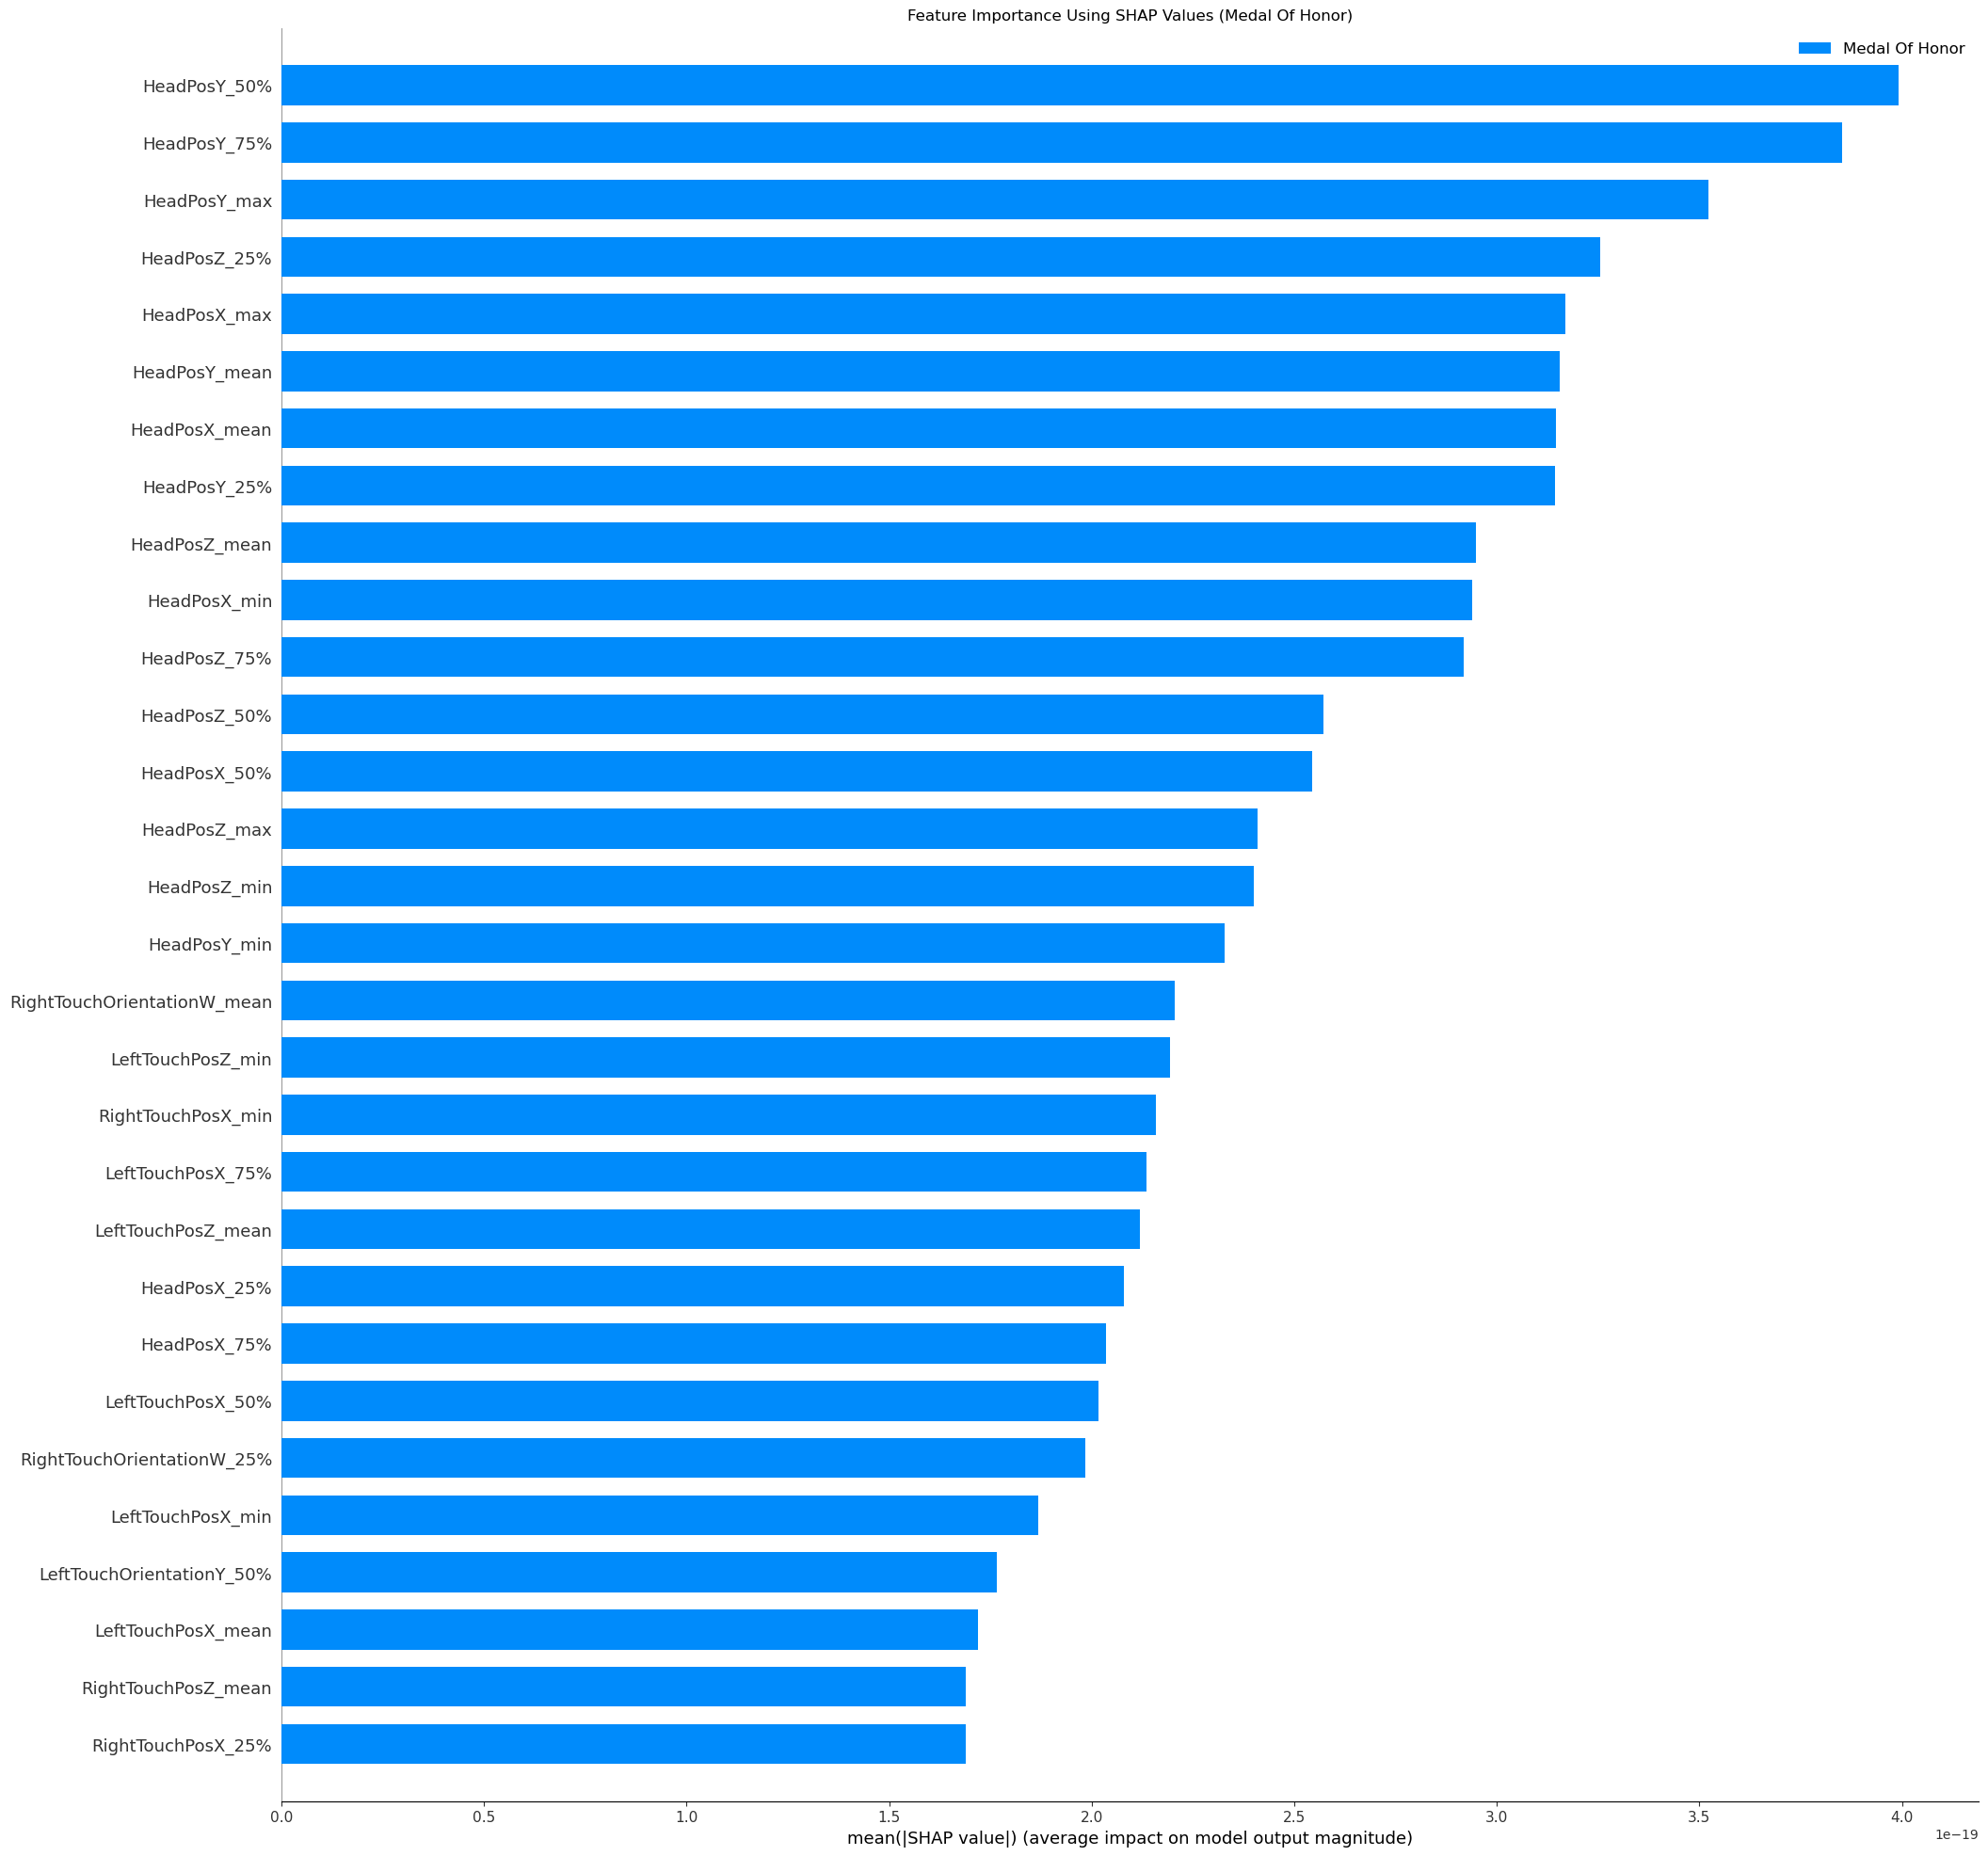

In [35]:
VisualizationUtils.shap_plotter([np.mean(shap_values_fast, axis=2)], 
                          fX_test, title="Feature Importance Using SHAP Values (Medal Of Honor)",
                          class_names=['Medal Of Honor'])

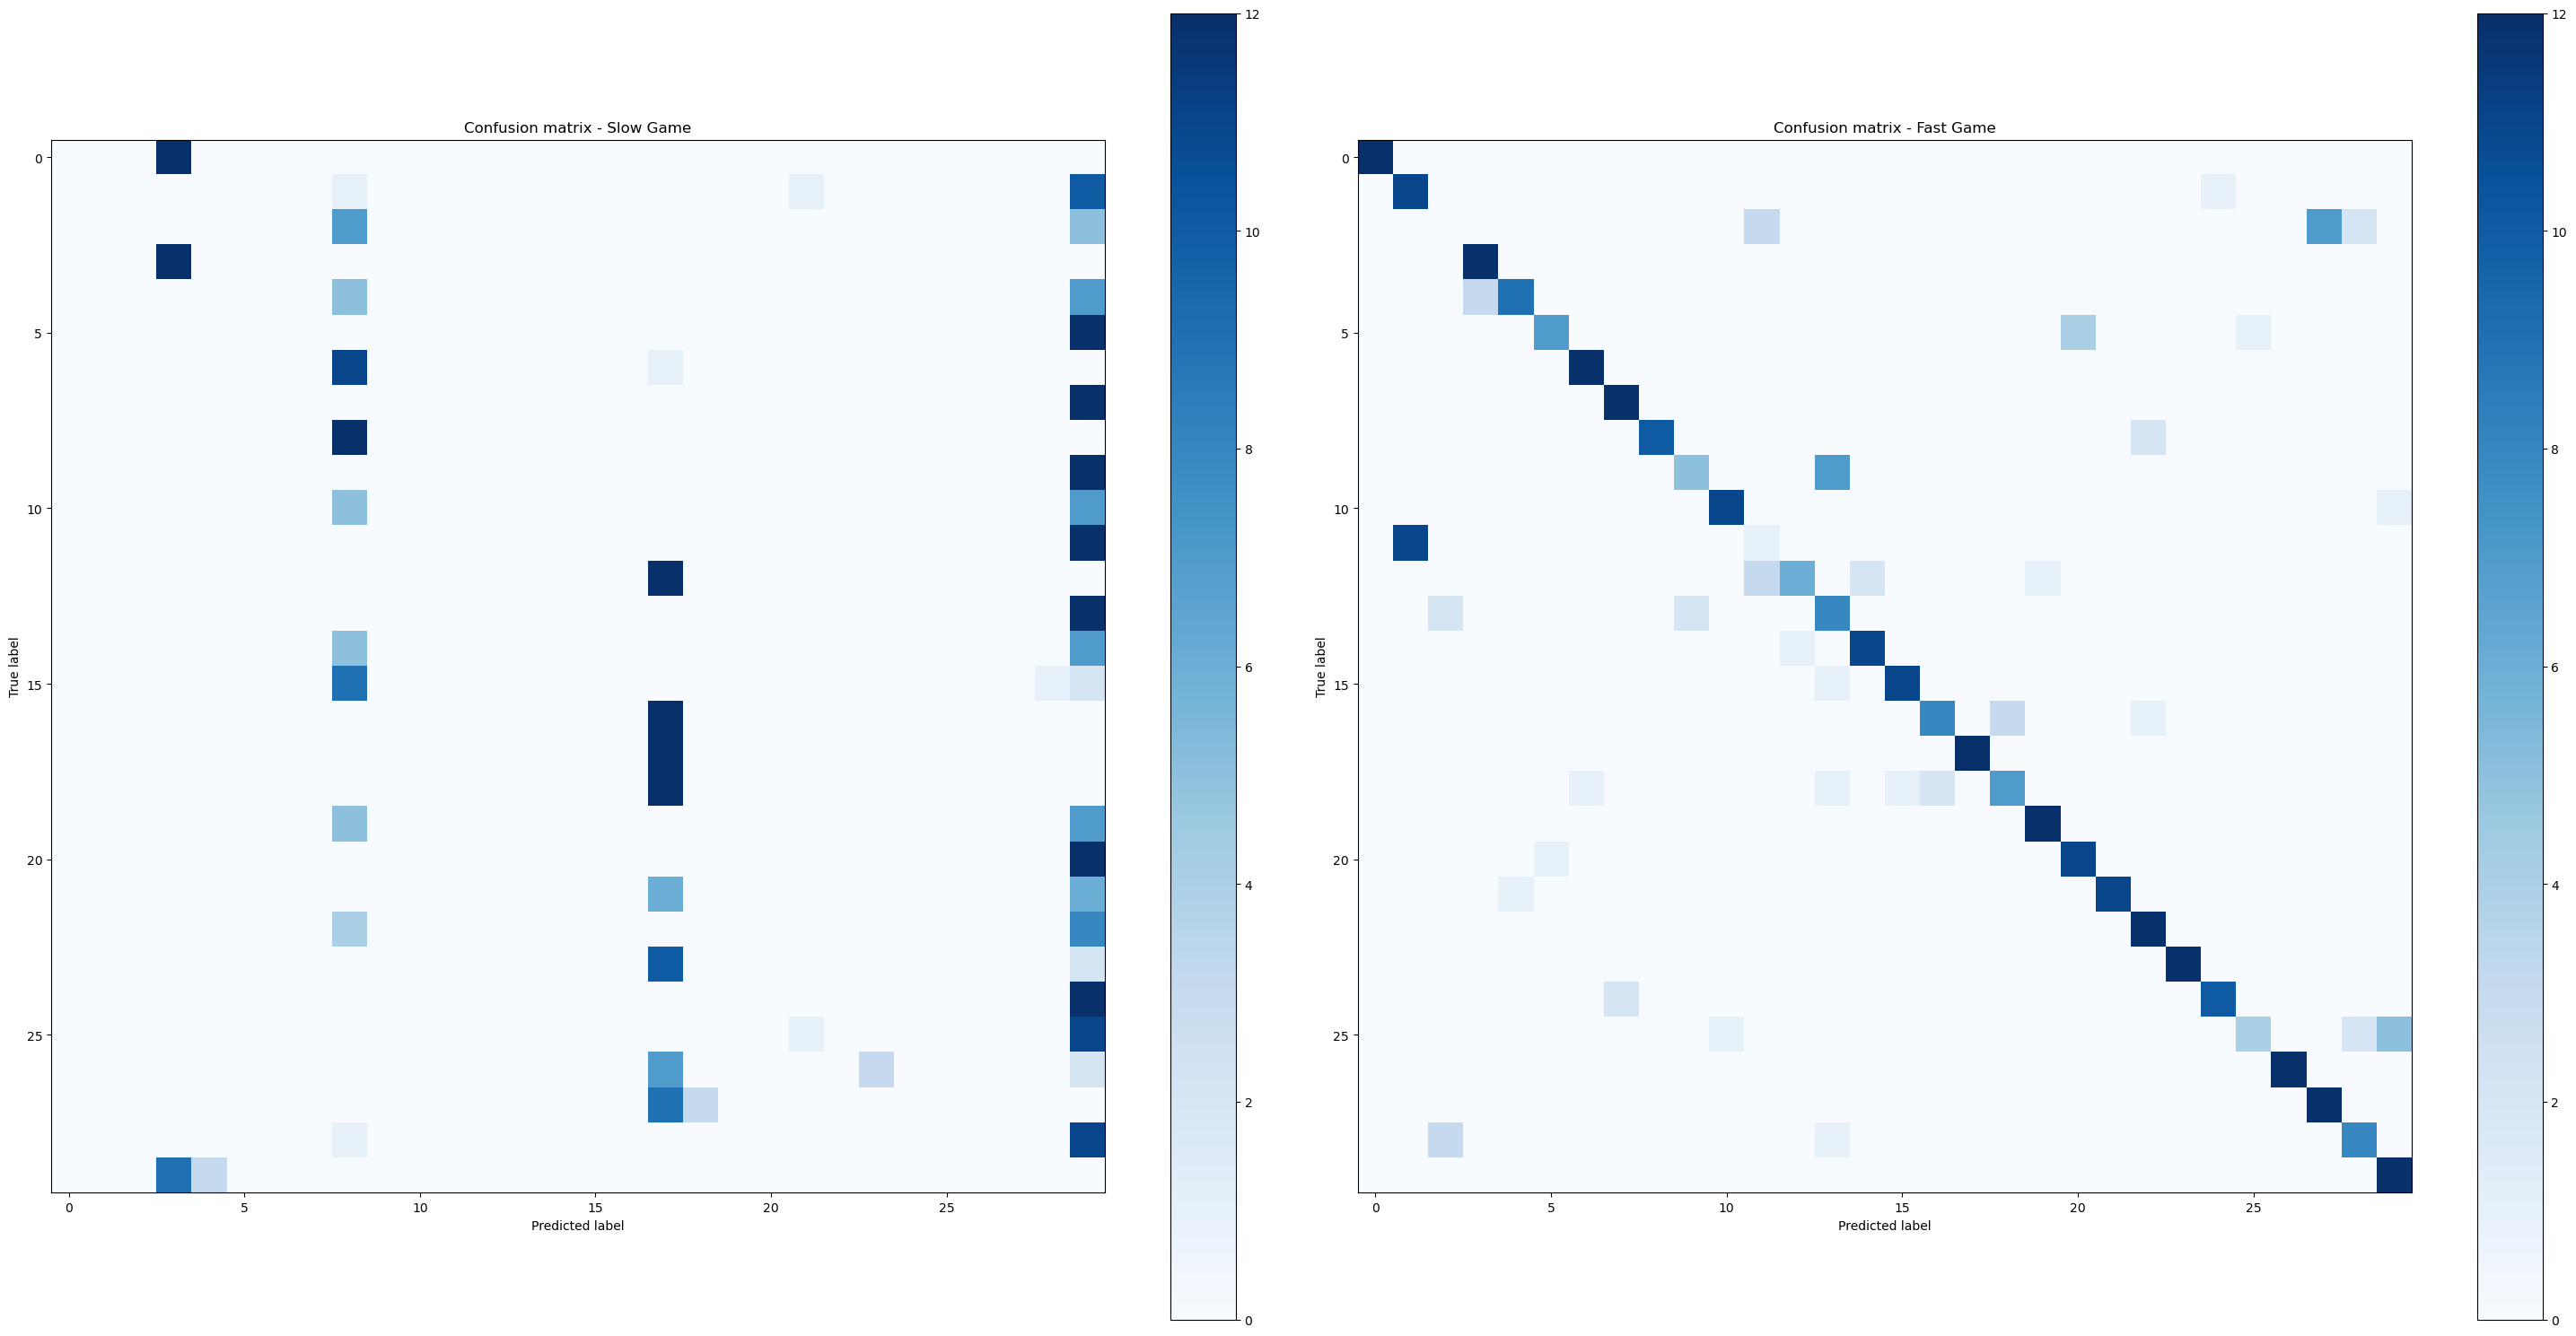

In [36]:
VisualizationUtils.confusion_matrices(cm_slow, cm_fast)

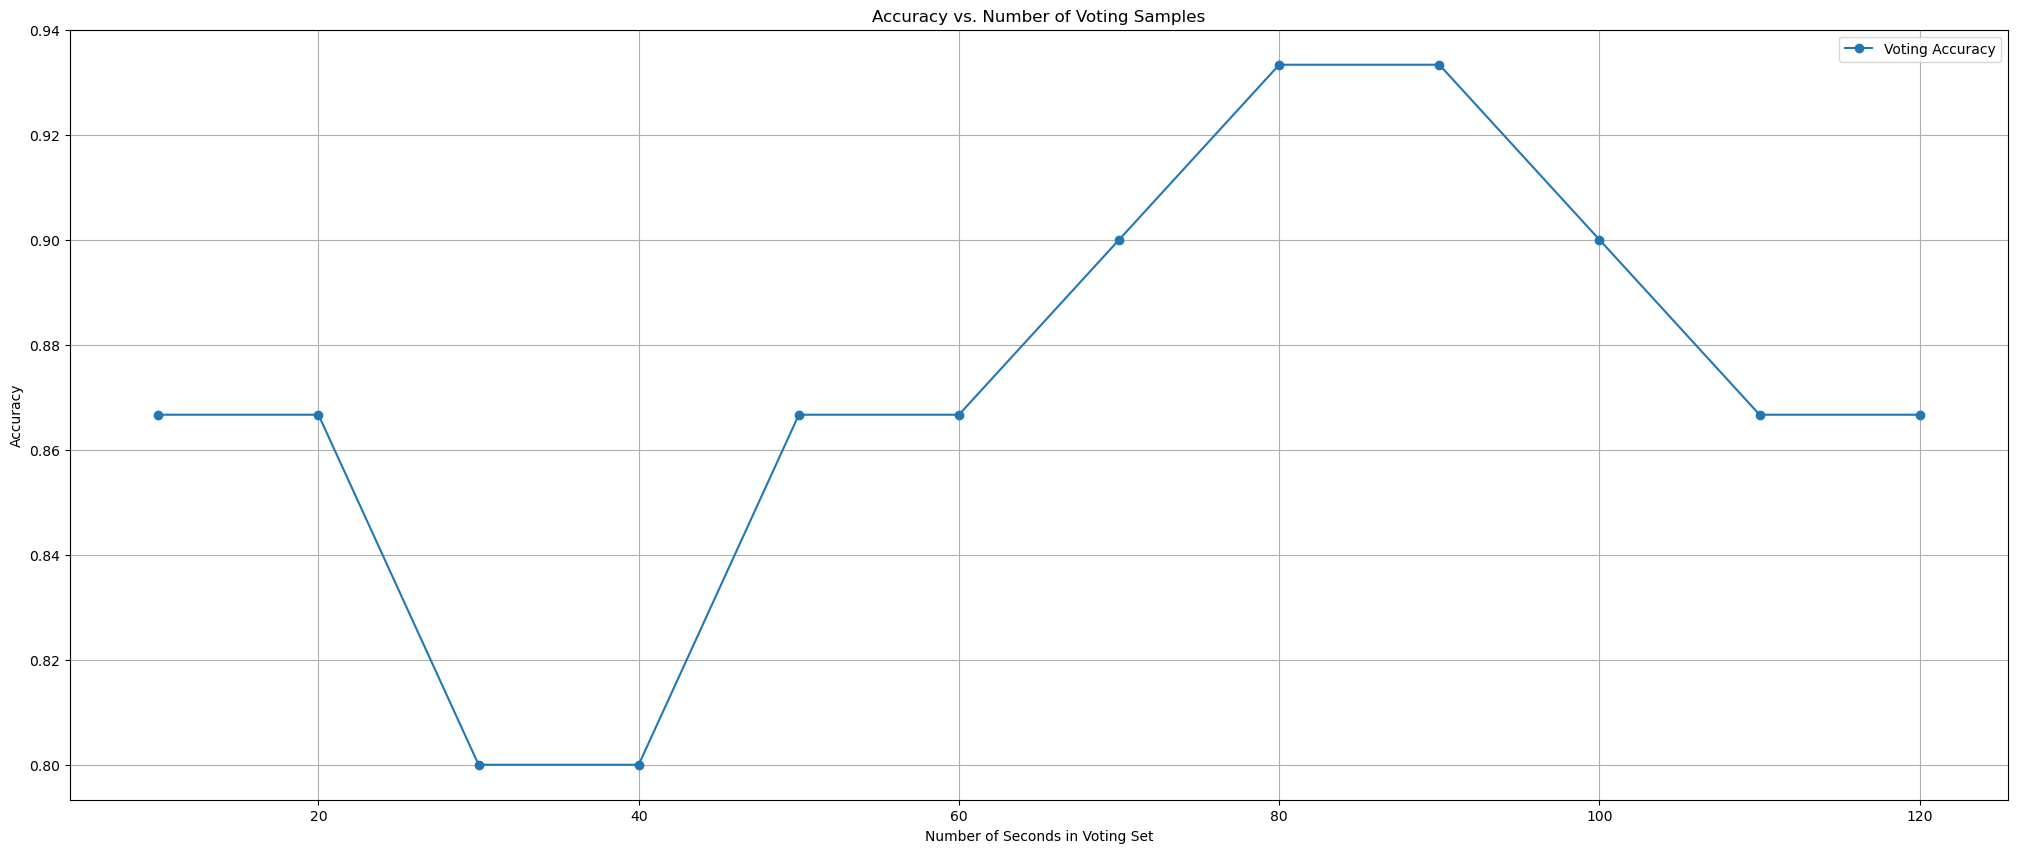


Vote Over Time Data Table:


,Seconds in Voting Set,Voting Accuracy
0,10,0.866667
1,20,0.866667
2,30,0.800000
3,40,0.800000
4,50,0.866667
5,60,0.866667
6,70,0.900000
7,80,0.933333
8,90,0.933333
9,100,0.900000


In [37]:
evaluator.plot_accuracy_by_vote(best_model_fast, fX_test, fy_test, increment=1)

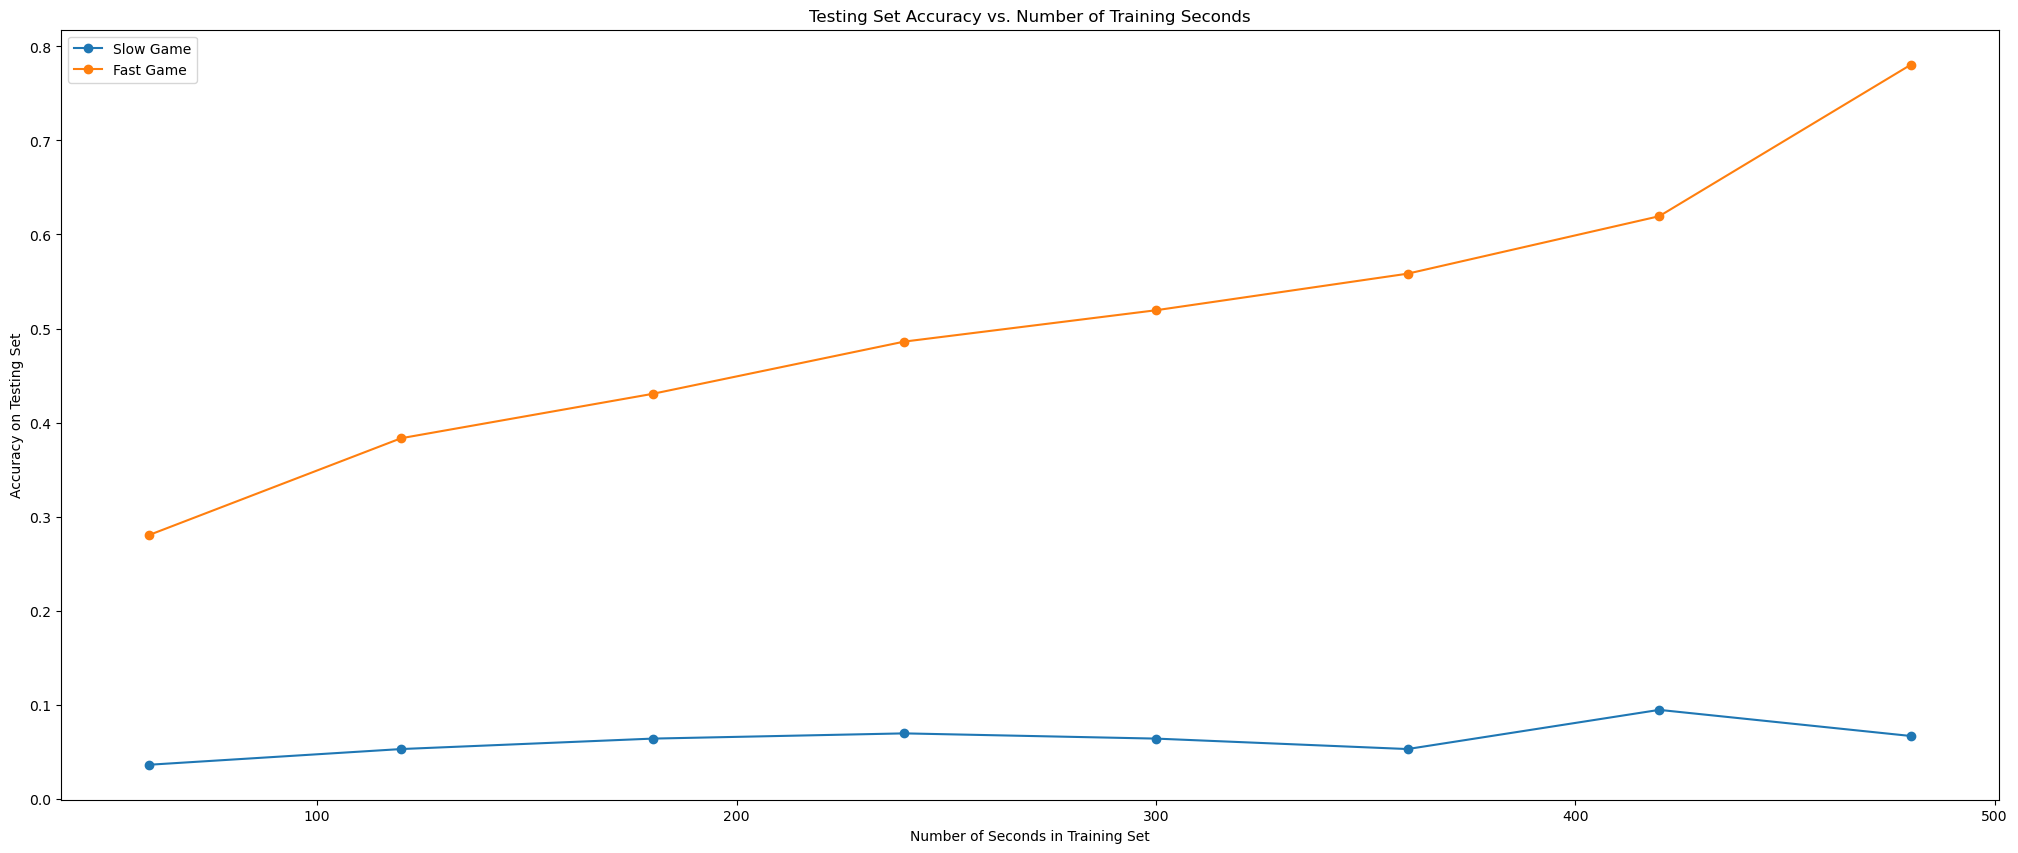


Accuracy Over Time Data Table:


,Seconds in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,60,0.036111,0.280556
1,120,0.052778,0.383333
2,180,0.063889,0.430556
3,240,0.069444,0.486111
4,300,0.063889,0.519444
5,360,0.052778,0.558333
6,420,0.094444,0.619444
7,480,0.066667,0.780556


In [38]:
evaluator.accuracy_over_time(fX, fy,best_model_fast_name, range(1,9), X_test, y_test, fX_test, fy_test)

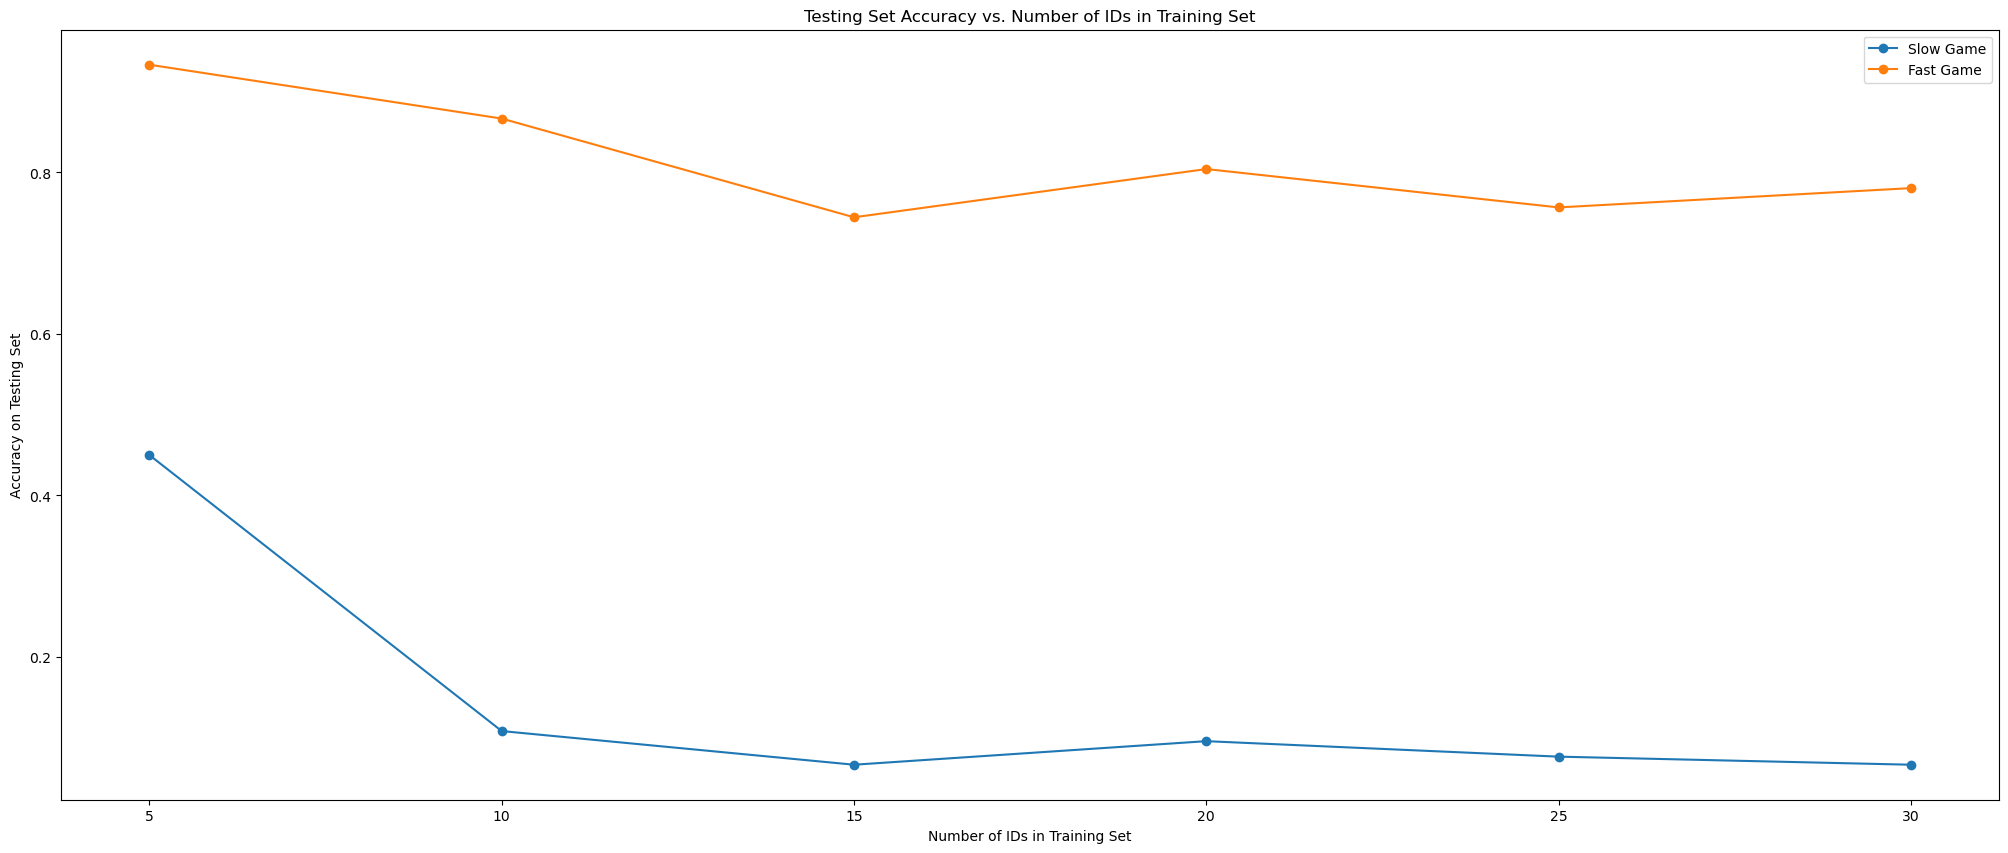


ID Over Time Data Table:


,Number of IDs in Training Set,Slow Game Accuracy,Fast Game Accuracy
0,5,0.450000,0.933333
1,10,0.108333,0.866667
2,15,0.066667,0.744444
3,20,0.095833,0.804167
4,25,0.076667,0.756667
5,30,0.066667,0.780556


In [39]:
evaluator.accuracy_over_ids(fX_train, fy_train,best_model_fast_name, X_test, y_test,fX_test, fy_test)